# Lab 2: Comparing Means 
## W203 Statistics for Data Science

### Group Members 
* Devesh Khandelwal
* John Lee
* Jocelyn Lu

# Introduction

We are tasked to use the ANES dataset to address five research questions. Details about the approach for each question are provided in their respective sections. 

Before we dive into the ANES data, we wanted to discuss some preliminary properties of the survey data provided.

## Selection Bias

The lab introduction and the ANES User Guide mention that survey participants are taken from the YouGov panel, which is an online system in which volunteer respondents receive points worth 21 to 50 cents for each survey completed. This was also a "non-probability sample", where participants will deliberately opt-in to take to take the survey. Thus, for this dataset, we will see some selection bias from only including this subset of the population, which may not be representative of the overall U.S. population. 


To get a better idea of the selection bias we may encounter, we do some basic data exploration on the demographics of the survey participants.

### Data Load/Set-Up

In [150]:
options(warn = -1)

library(ggplot2)
library(ggpubr)
library(effsize)
library(dplyr)
library(tidyr)
library(maps)

In [151]:
survey = read.csv("anes_pilot_2018.csv")

In [152]:
survey_demographics <- survey %>% select(birthyr, gender, educ, inputstate)

In [153]:
# Enums provided by the user guide and by https://electionstudies.org/2018-pilot-study-updates-errata/

survey_demographics <- survey_demographics %>%
mutate(
    age = 2018 - birthyr,
    gender = recode(
        gender, 
        `1` = 'Male', 
        `2` = 'Female'),
    education = factor(
        recode(
            educ,
            `1` = 'No HS',
            `2` = 'High School graduate',
            `3` = 'Some college',
            `4` = '2-year',
            `5` = '4-year',
            `6` = 'Post Grad'
        ),
        levels = c("No HS", "High School graduate", "Some college", "2-year", "4-year", "Post Grad")
    ),
    state = recode(
        inputstate,
        `1` = 'Alabama',
        `2` = 'Alaska',
        `4` = 'Arizona',
        `5` = 'Arkansas',
        `6` = 'California',
        `-7` = 'Colorado',
        `-1` = 'Connecticut',
        `10` = 'Delaware',
        `11` = 'District of Columbia',
        `12` = 'Florida',
        `13` = 'Georgia',
        `15` = 'Hawaii',
        `16` = 'Idaho',
        `17` = 'Illinois',
        `18` = 'Indiana',
        `19` = 'Iowa',
        `20` = 'Kansas',
        `21` = 'Kentucky',
        `22` = 'Louisiana',
        `23` = 'Maine',
        `24` = 'Maryland',
        `25` = 'Massachusetts',
        `26` = 'Michigan',
        `27` = 'Minnesota',
        `28` = 'Mississippi',
        `29` = 'Missouri',
        `30` = 'Montana',
        `31` = 'Nebraska',
        `32` = 'Nevada',
        `33` = 'New Hampshire',
        `34` = 'New Jersey',
        `35` = 'New Mexico',
        `36` = 'New York',
        `37` = 'North Carolina',
        `38` = 'North Dakota',
        `39` = 'Ohio',
        `40` = 'Oklahoma',
        `41` = 'Oregon',
        `42` = 'Pennsylvania',
        `44` = 'Rhode Island',
        `45` = 'South Carolina',
        `46` = 'South Dakota',
        `47` = 'Tennessee',
        `48` = 'Texas',
        `49` = 'Utah',
        `50` = 'Vermont',
        `51` = 'Virginia',
        `53` = 'Washington',
        `54` = 'West Virginia',
        `55` = 'Wisconsin',
        `56` = 'Wyoming'
    )
)

### Age

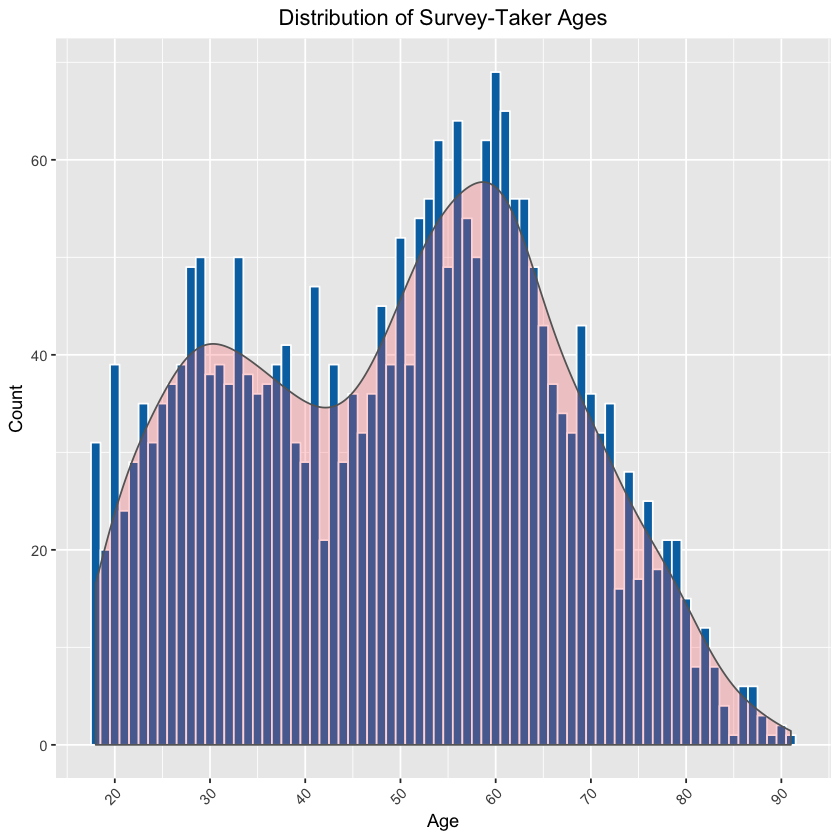

In [154]:
ggplot(survey_demographics %>% 
           filter(age != 0), 
       aes(age)) + 
    geom_histogram(fill = "#0072B2", binwidth = 1, color="white") + 
    geom_density(aes(y = ..count..), alpha=0.25, fill = "#FF6666", color = 'grey40') +
    scale_x_continuous(breaks = round(seq(0, max(survey_demographics$age), by = 10), 1)) +
    xlab("Age") + ylab("Count") + 
    ggtitle("Distribution of Survey-Taker Ages") +
    
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle = 45, hjust = 1))

We see that the age groups in this dataset are not a representative sample of the population. While the [two largest age groups in the U.S. at the time of the survey were the late 20s and late 50s/60s](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/), the latter group is highly overrepresented in this sample.

### Gender

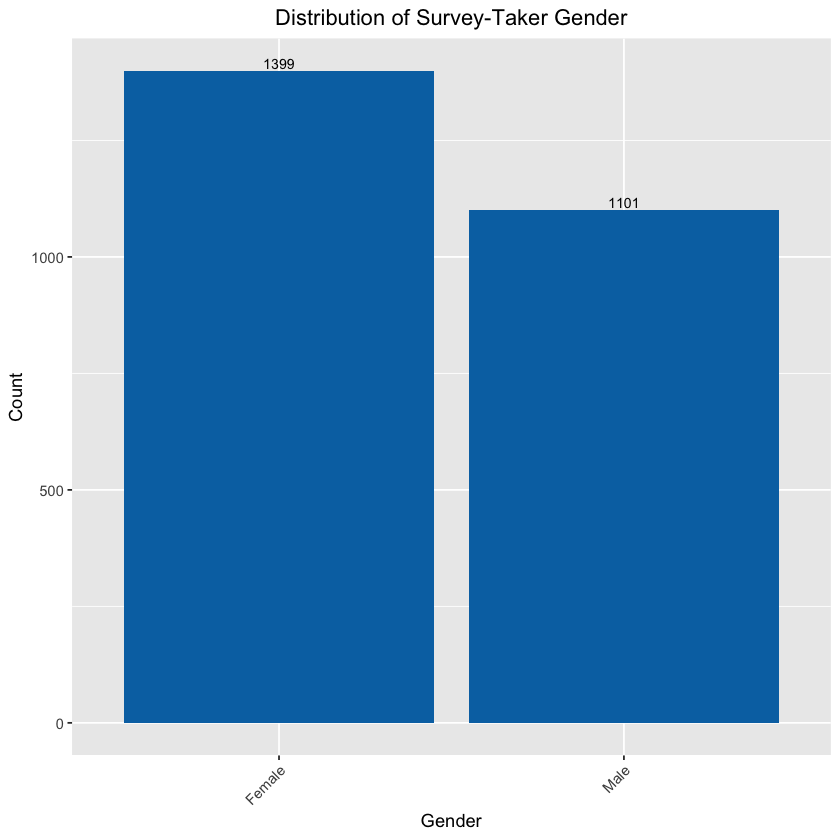

In [155]:
ggplot(survey_demographics %>% filter(!is.na(gender)), aes(as.factor(gender))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Gender") + ylab("Count") + 
    ggtitle("Distribution of Survey-Taker Gender") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)

We see a similar issue with gender. The [proportion of males to females in the U.S. is roughly equal](https://www.statista.com/statistics/737923/us-population-by-gender/), and yet, females are overrepresented in this sample. 

The discrepancy that we see here in both gender and age is likely due to the type of people who may be more inclined to be taking surveys on the YouGov site. 

### State

We are also interested in the breakdown of location of survey responders.

In [156]:
survey_demographics_by_state <- survey_demographics %>% 
    mutate(state = tolower(state)) %>% 
    group_by(state) %>%
    summarise(
        total = n(),
        mean_age = mean(age, na.rm = TRUE),
        median_age = median(age, na.rm = TRUE),
        ratio_male = sum(gender == "Male", na.rm = TRUE)/sum(gender == "Female", na.rm = TRUE),
        top_education_level = names(table(education))[which.max(table(education))],
    )

In [157]:
states <- map_data("state") %>% 
    rename(state = "region")

In [158]:
survey_demographics_by_state_map <- merge(states, survey_demographics_by_state, by = "state")

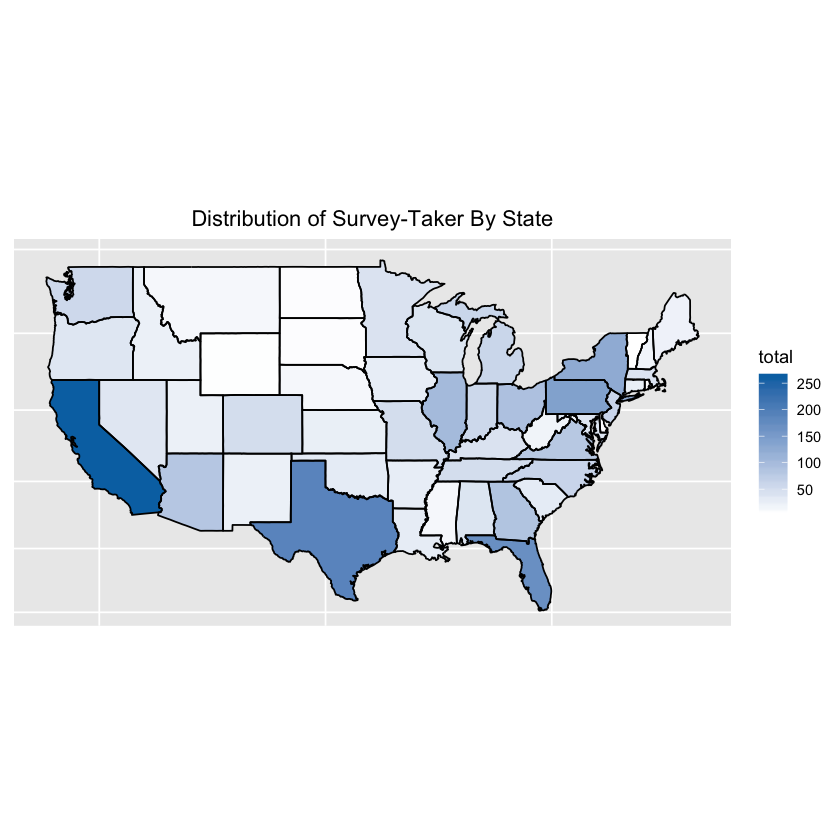

In [159]:
ggplot(survey_demographics_by_state_map, aes(x = long , y = lat, group = group)) +
    geom_polygon(aes(fill = total)) +
    geom_path() + 
    scale_fill_gradient(low = "white", high = "#0072B2", na.value = "grey40") +
    coord_map() + 
    theme(
        plot.title = element_text(hjust = 0.5),
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    ) + 
    xlab(NULL) +
    ylab(NULL) +
    ggtitle("Distribution of Survey-Taker By State")

We see that while the proportions per state aren't exactly correct, the distribution generally follows what we expect to see in terms of population by state. 

In conclusion, we are reassured our study addresses location fairly well, after being given the bad news that gender and age may not be fairly represented in this study.

## Clustering Problem

Another issue we may encounter with this dataset is the standard sample clustering problem, where due to similarities between responders, the answers we get may not be independent. For instance, perhaps one person encourages his or her friends to all sign up and take this survey, and all have similar views around politics. As our sample is no longer i.i.d., this may violate the assumptions we need for testing. 

# Question 1: Do US voters have more respect for the police or for journalists?

In [160]:
# Variable of interest "ftpolice"
# There are 2500 data points and there are no missing values.
# The missing values have been docoded as <0 with the options as indicated in the guide- :

paste("Total number of voters who have rated police-->" , sum(survey$ftpolice > 0))
paste("Total number of voters who have rated Journalists-->" , sum(survey$ftjournal > 0))

[1] "Total number of voters who have rated police--> 2469"

[1] "Total number of voters who have rated Journalists--> 2416"

## Introduce your topic briefly.

### Introduction

We are interested to find out whether a US voter respects Police more, on average, than a Journalist.

### Interest 

There is a general interest to gauge how favorable a US voter is to Police than a Journalist as this could directly determine how his/her voting preferences.

### Methodology

The survey uses the following methodology:

1. Each respondent is asked to rate these 2 variable on a scale ranging from (very cold/unfavorable - encoded as 0) to (very warm/favorable - encoded as 100).
2. The response to these questions are non-mandatory, however a numeric code is assigned(instead of a system missing e.g. NA) when a participant skips/choses not to respond.

### Concepts

We are given 2 ordinal variables(because there is an inherent order between the responses but we can't quantify the difference between the responses)which have a possible range of values.We are measuring the response by the values of these variables.

To successfully interpret the data and determine whether voters respect Police or Journalist,one must understand the concepts of ranking and hypothesis testing of ordinal data.

In order to make a decision:

1. Construct a hypotheses
2. Perform a dependent test(since there is a pairing. Same individual answers questions on Police and Journalist)
3. An appropriate test in this scenario is a "Signed-Rank" test. Due to the ordinal nature of the variables.

*ASSUMPTION* - We'll assume that the ratings on Police is independent of the ratings on Journalist and there is no correlation between the two.

## Perform an exploratory data analysis (EDA) of the relevant variables.

In [161]:
summary(survey$ftpolice)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   47.00   70.00   64.68   90.00  100.00 

In [162]:
summary(survey$ftjournal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -7.00   21.00   52.00   52.26   82.00  100.00 

In [163]:
# for ftpolice -> There are no missing records that are coded as values <0
# for ftjournal -> There are a missing records that is coded as a negative value.

### Few things to note about the data

1. Since we are making comparisons , we need to exclude individuals who did not respond to the question..
2. We are considering registered voters only and need to exclude responses from an unregisterred voter.

In [164]:
# creating a new dataframe with a subset of values
# Reg = 3 indicates that the person is not registered to vote
# We also need to omit the voters who have given the same ratings for police and journalists. This is because we are conducting a signed test
# And while conducting a signed test we are interested in calculating the change in "signs"

df = subset(survey, survey$ftjournal >= 0 &  survey$reg!=3 &  survey$ftjournal != survey$ftpolice)

In [165]:
summary(df$ftjournal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   20.00   56.00   53.86   86.00  100.00 

In [166]:
summary(df$ftpolice)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    50.0    74.0    67.7    91.0   100.0 

The output above successfully validates that the missing values(coded as < 0) have been removed. 

### Histogram Analysis

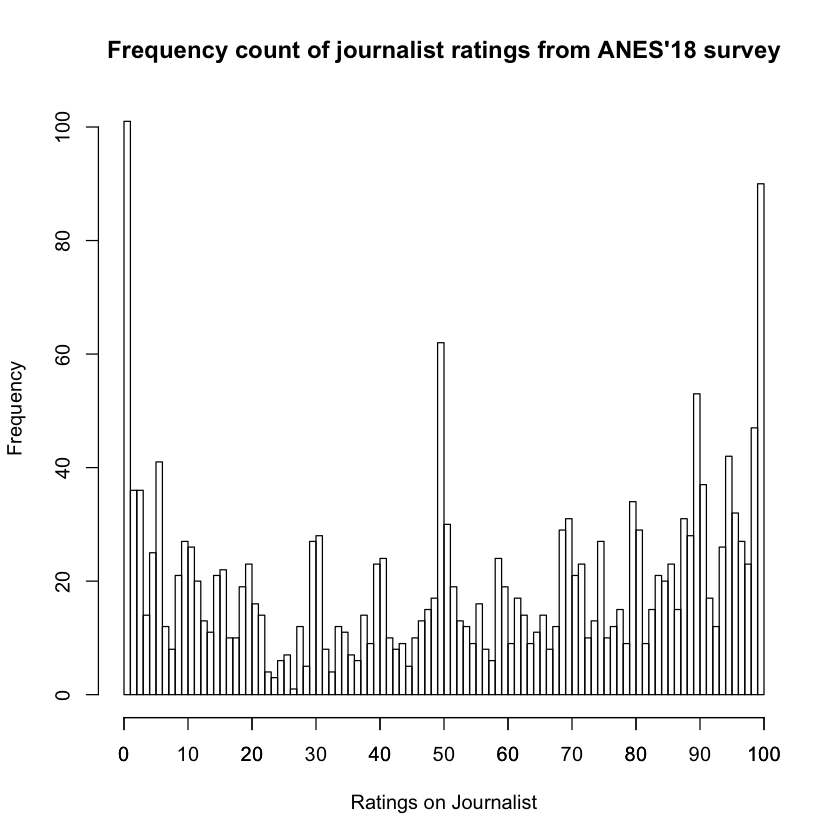

In [167]:
hist(df$ftjournal , breaks = 100,main = "Frequency count of journalist ratings from ANES'18 survey" , xlab = "Ratings on Journalist" )
axis( 1 ,at = c((0:10)*10) )

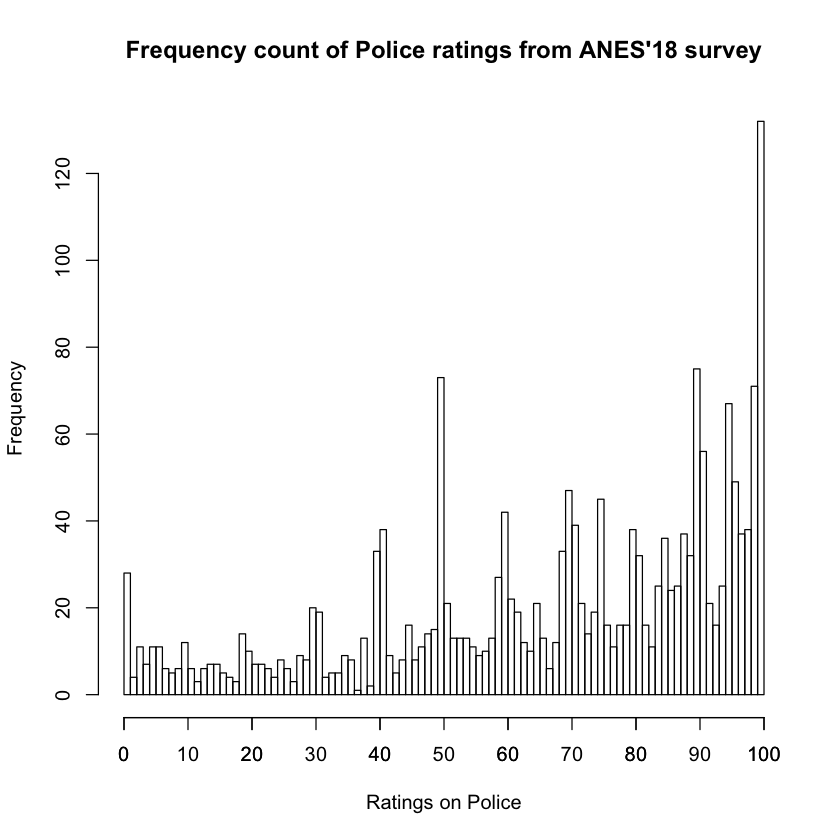

In [168]:
hist(df$ftpolice , breaks = 100,main ="Frequency count of Police ratings from ANES'18 survey" , xlab = "Ratings on Police" )
axis( 1 ,at = c((0:10)*10) )

**HISTOGRAM ANALYSIS**

1. Count variables
    * The valid values are between 0 and 100.
    * This further validates that that missing values(<0)have been removed.
    * This should be considered when modeling and selecting the right model for integer values. 
2. Skewness:
    * People tend to rate police higher than journalists.
        * Police histogram has a negative skew as evident from the output of the summary (Median > Mean)
        * Journalist histogram seems to be fairly balanced (Median = Mean)

### Box Plot Analysis

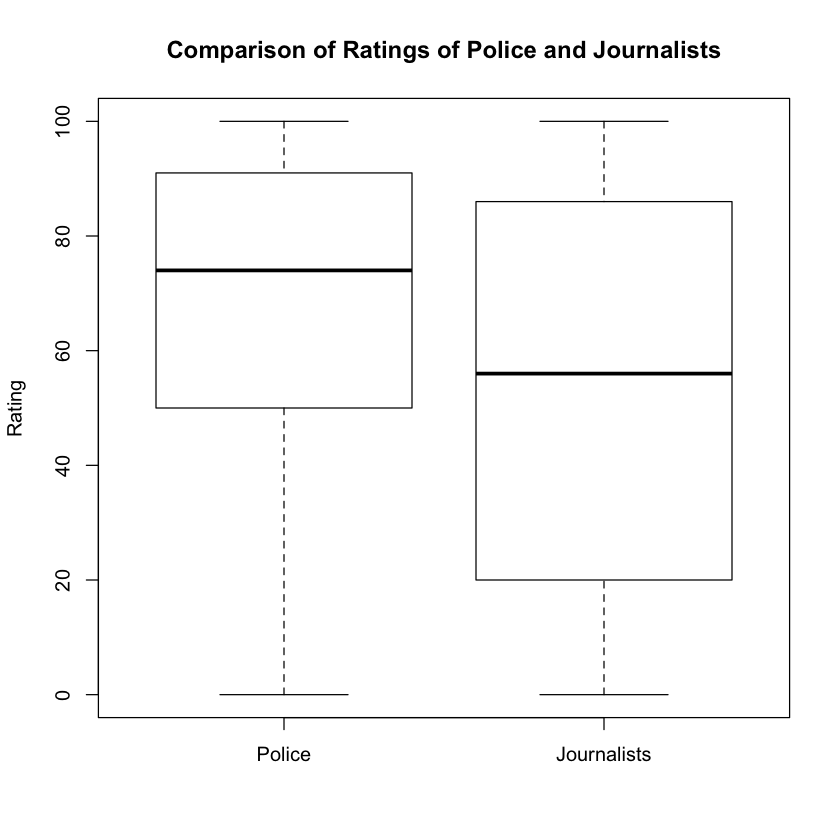

In [169]:
boxplot(df$ftpolice ,df$ftjournal ,data = df ,
        main = "Comparison of Ratings of Police and Journalists" ,names =c("Police" , "Journalists"),
        ylab = "Rating")

#### Median Rating

As evident from the box plot above the median ratings for journalists are lower than that of Police

## Based on your EDA, select an appropriate hypothesis test.

### Underlying data and type of variables

1. The variables(rating on journalists and police) are ordinal.
2. There is a logical pairing between the 2 variables(The same person is responding to both questions)

### Conclusion

Because of (1) and (2) above - A "binomial-test" would be applicable.

### Assumption for a Signed Test

1. Ordinal scale - The assumption for an ordinal scale is satisfied. We have the response on a "thermometer scale" where a participant indicates his/her rating on police/journalist. The rating variable is Ordinal because:
     * We dont know if the difference between "Very Cold" and "Quite Cold" is same as "Fairly cold" and "Bit more cold"
     * We certainly know that "Quite cold" > "Very Cold"
2. The two random variables are drawn independently - We are assuming that a person's feeling on journalist is independent from that of police and vice-versa.

Note - (2) above is an assumption for the test.


## Conduct your test.

**$H_0$: Null Hypothesis**

* P(+) = P(-) i.e. the probability of a positive rating on Police is same as the probability of a negative rating on a journalist.

**$H_a$:Alternate Hypothesis**

* P(+) != P(-) i.e. The probability of a positive rating on police is more than the probability of a negative rating on a journalist.

For this analysis, we look only at the voters who rated police and journalists differently. Then, we compare the preference between the two. 

In [170]:
nrow(df)
paste("Total number of voters who have rated police and journalist differently ->", nrow(df))

[1] 1967

[1] "Total number of voters who have rated police and journalist differently -> 1967"

In [171]:
plusses = df$ftpolice - df$ftjournal
vec = sum(plusses > 0)
binom.test(x = vec, n = 1967, p = 0.5, "two.sided")


	Exact binomial test

data:  vec and 1967
number of successes = 1112, number of trials = 1967, p-value =
7.465e-09
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.5430832 0.5873776
sample estimates:
probability of success 
             0.5653279 


In [172]:
cohen.d(df$ftpolice, df$ftjournal, paired = TRUE)


Cohen's d

d estimate: 0.4518607 (small)
95 percent confidence interval:
    lower     upper 
0.3796556 0.5240657 

### Summary of Tests 

The result is statistically significant since p-value is extremely small. 

We therefore reject the null hypothesis, $H_0$. In this case, U.S. voters have more respect for police than for journalists. 

However, the Cohen's D value indicates that the effect size is small, indicating that the change in the ratings between a journalist and police is not pratically significant. 

# Question 2: Are Republican voters older or younger than Democratic voters?

## Introduce your topic briefly.

### Introduction

We are interested in finding out if there is any relationship between age and political preferences.

### Interest

The stakeholders in the election may be interested in understanding the corelation between "age" and voting pattern.

### Methodology 

The survey determines the political inclination of a voter by asking them specific questions.The response to these questions are captured in the following variables:

1. Pid1d
2. Pid1r
3. Pidlean

These variables identify the affiliation to the parties Democratic and Republican respectivelty.

The workflow is structured as follows

1. A system generated random variable(RandPid) governs the display of selection choices for a user to indicate his/her support.
2. A question is presented to the user to identify whether he supports Democrats or Republicans.
3. The user's selection is recorded in a variable Pid1d which indicates his preference:
4. If a user indicates support to an indipendent candidate OR he supports someone else(Pid1d=3 or 4 OR Pid1r=3 or 4) or if he doesn't provide an answer:
5. Another question is asked to further check his affiliation.
    * The response(Pidlean) tracks whether the respondant is leaning to support Republican(Pidlean=1) or Democrat(Pidlean=2)

### Total Voters

Thus, we can identify the total number of voters by adding the variables(refer EDA below).



## Perform an exploratory data analysis (EDA) of the relevant variables.


In [173]:
summary(survey$pid1d)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -7.000  -1.000  -1.000   0.412   2.000   4.000 

In [174]:
# We need to perform the analysis on the people who've registered to vote.
# reg = 3 => that the person has not regisered to vote. 
df_voters = subset(survey,  survey$reg!=3 )

In [175]:
# Based on the analysis in part 1 above, the total # of democrat supporters is the sum 
# (Pid1d == 1) + (Pid1r == 1) + (Pidlean == 2):
# Based on the analysis in part 1 above, the total # of republican supporters is the sum 
# (Pid1d == 2) + (Pid1r == 2) + (Pidlean == 1)
#3.1.1 Pid1d =1 => Democrat supporter
# 3.1.2 Pid1d =2 => Republican supporter
# 3.1.3 Pid1d =3 => supports an independent candidate
 #3.1.4 Pid1d =4 => supports someone else
dem = subset(df_voters, (df_voters$pid1d == 1) | (df_voters$pid1r == 1) | (df_voters$pidlean == 2))

paste("The number of Democratic voters are:", nrow(dem))

[1] "The number of Democratic voters are: 1019"

In [176]:
# Based on the analysis in part 1 above, the total # of republican supporters is the sum 
# (Pid1d == 2) + (Pid1r == 2) + (Pidlean == 1)
#3.1.1 Pid1d =1 => Democrat supporter
# 3.1.2 Pid1d =2 => Republican supporter
# 3.1.3 Pid1d =3 => supports an independent candidate
 #3.1.4 Pid1d =4 => supports someone else
rep = subset(df_voters ,  (df_voters$pid1d == 2) | (df_voters$pid1r == 2) | (df_voters$pidlean == 1))

paste("The number of Republican voters are: ",nrow(rep))

[1] "The number of Republican voters are:  748"

### Calculating the age of voters

**Assumption**

The age is an approximate age from the year of birth to 2018.

In [177]:
# We do not have age as an attribute of the data set.
# Calculating the age as approximate number of years from the yr of birth to the time of survey.2018
# We will derive a new feature called age.
dem$age = 2018 - dem$birthyr

rep$age = 2018 - rep$birthyr

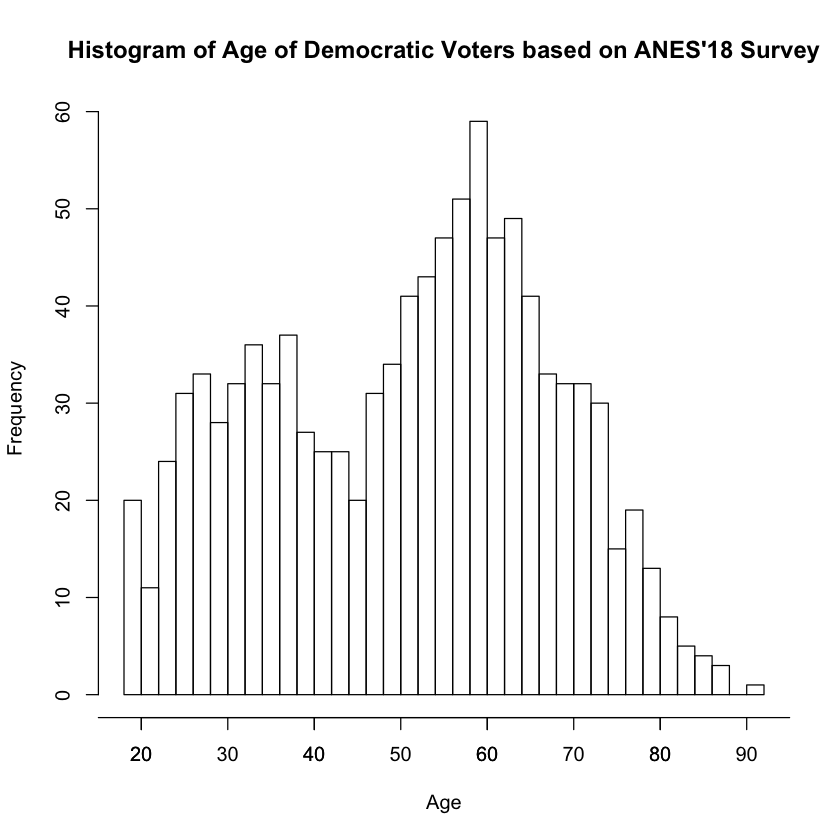

In [178]:
hist(dem$age, breaks = 50, main = "Histogram of Age of Democratic Voters based on ANES'18 Survey", xlab = "Age")
axis(1, at = c((0:10)*10) )

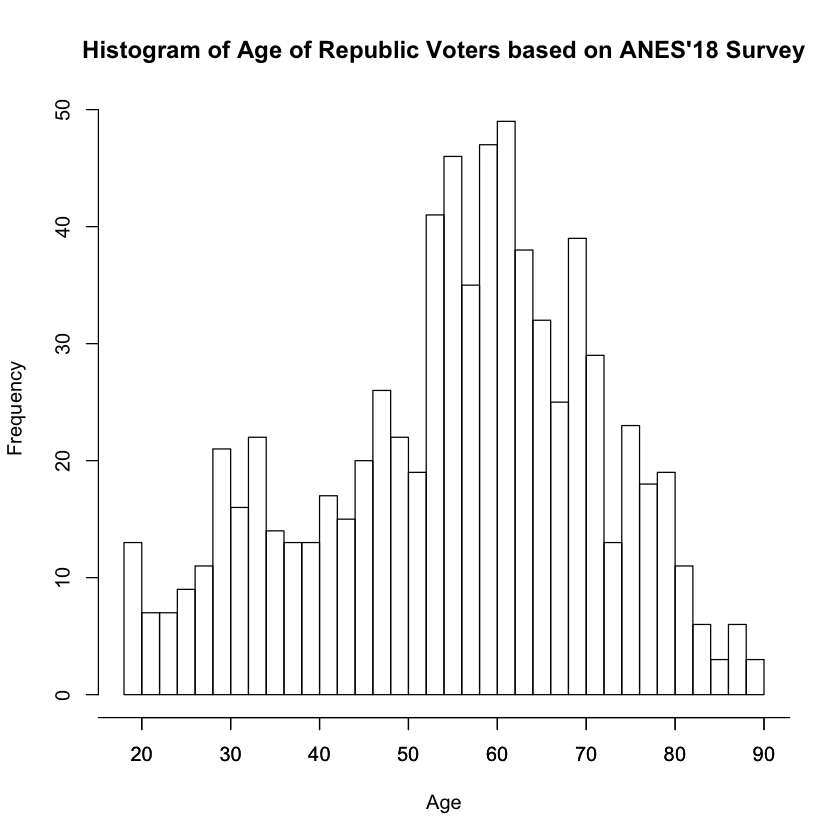

In [179]:
hist(rep$age, breaks = 50, main = "Histogram of Age of Republic Voters based on ANES'18 Survey", xlab = "Age")
axis(1, at = c((0:10)*10) )

### Analysis from Histogram

1. On an average there are less number of republican voters in the 20-50 age group.
2. On an average a larger percentage of people favor republican in the age group 80 and above.

In [180]:
df_age = rbind(dem$age, rep$age, rm.na = T)

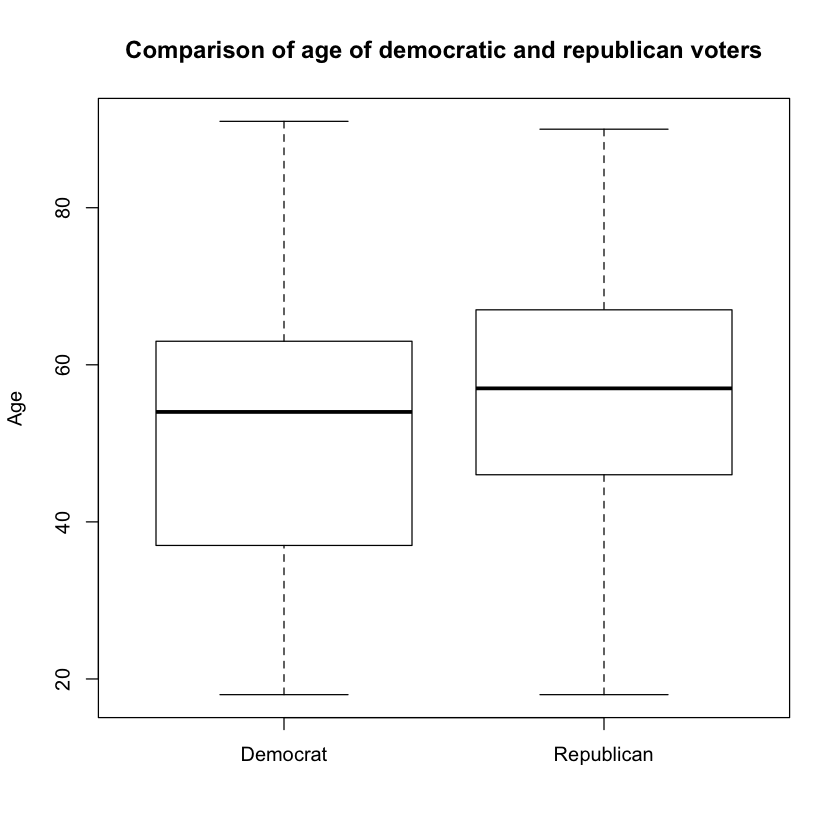

In [181]:
boxplot(dem$age, rep$age, data = df_age, 
        main = "Comparison of age of democratic and republican voters" ,names =c("Democrat" , "Republican"),
        ylab = "Age")

### Analysis From Box Plot

1. Though the number of voters in the 2 categories are not the same, but it is evident that republican voters are older than democrat ones.

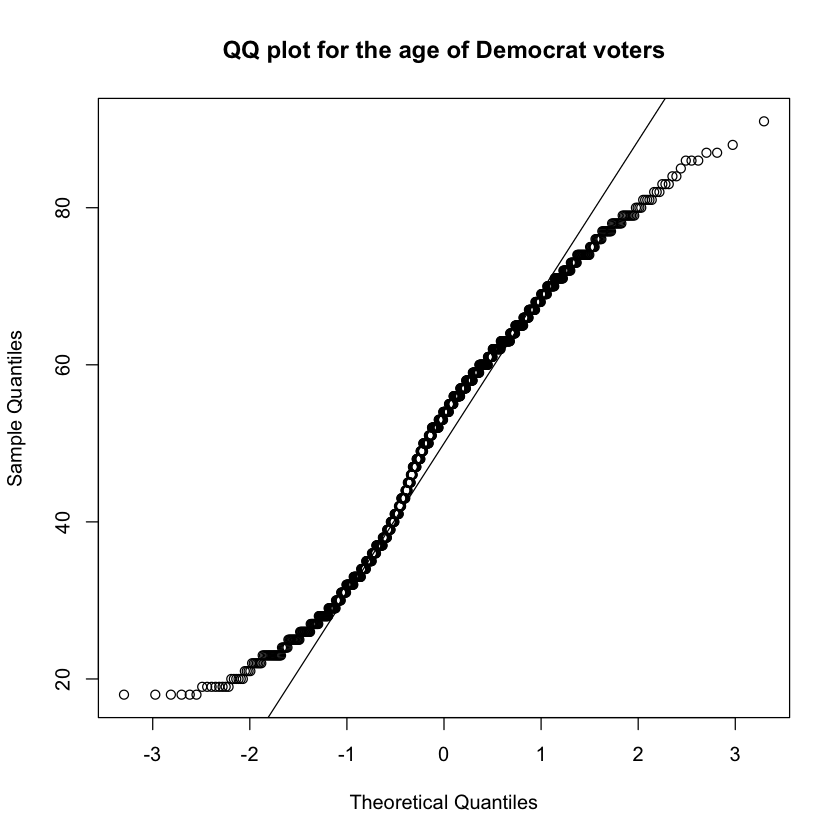

In [182]:
qqnorm(dem$age, main = "QQ plot for the age of Democrat voters" )
qqline(dem$age)

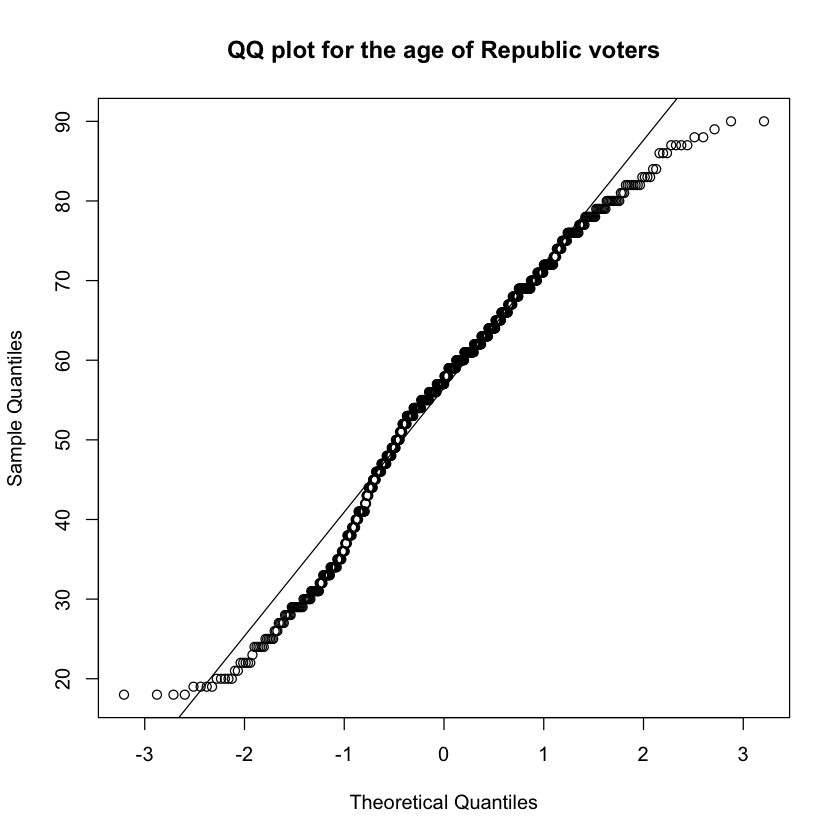

In [183]:
qqnorm(rep$age, main = "QQ plot for the age of Republic voters" )
qqline(rep$age)

### Observations from QQ Plots

1. The data is skewed.
2. There is significant deviations from normality.
3. We'll need a big enough sample size in order to conduct a statistical test that needs a normal distribution for the CLT to be applicable.

## Based on your EDA, select an appropriate hypothesis test.

### Hypothesis

1. Null Hypothesis $H_o$: mean(age_dem_voter) = mean(age_rep_voter)
2. Alternate hypothesis $H_a$: mean(age_dem_voter) != mean(age_rep_voter)

### Test

1. We'll use a 2-tailed T-test

### Validity of Assumptions

1. **Normality**
    * The sample size is large enough to apply the CLT.
    * Due to the large sample-size is it safe to assume normality.
    
2. **Independence**
    * We are assuming that there is no clustering in the dataset.
    * Also it is being assumed that the participants are randomly sampled without any particular clustering.
                        
3. **Metric scale**
    * Our variables(age is metric)
    
4. **Identical Distribution**
    * Both set of voters(Democratis and Republicans) come from the same distribution


## Conduct your test.


In [184]:
paste("The variance in the age of democratic voters:", var(dem$age))
paste("The variance in the age of republican voters:", var(rep$age))


[1] "The variance in the age of democratic voters: 274.577687975615"

[1] "The variance in the age of republican voters: 256.799740852895"

In [185]:
# Since the variance of the 2 samples are not equal, we are conducting a pooled T test (var.equal = True)
t.test(x = dem$age, y = rep$age, data = df_age, mu = 0, var.equal = TRUE)


	Two Sample t-test

data:  dem$age and rep$age
t = -5.6158, df = 1765, p-value = 2.268e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.961885 -2.875462
sample estimates:
mean of x mean of y 
 51.22571  55.64439 


### Analysis of T-test

1. p-value is extremely small.
2. Null hypothesis can be rejected in favor of alternate hypothesis.
3. Democratic voters are younger than Republican ones.

However, before we can conclude , we need to check the effect size.

In [186]:
cohen.d(dem$age, rep$age, na.rm = T, data = df_age)


Cohen's d

d estimate: -0.2703913 (small)
95 percent confidence interval:
     lower      upper 
-0.3652453 -0.1755373 

### Conclusion:

* Though the results are statistically significant but the effect size is small.
* We can reject the null hypothesis, but there is no *practical* difference in age of Democratic and Republic voters.

# Question 3: Do a majority of independent voters believe that the federal investigations of Russian election interference are baseless?

## Introduce your topic briefly.

### Introduction

We are interested in determining whether a majority of independent voters believe the federal investigations of Russian election interference are baseless. This analysis may determine if subjects without a democrat-republican bias truly believes if the investigations were baseless. 

### Methodology

The survey includes a numeric code (instead of NA) when a participant skips/choses not to respond.

### Concepts 

We need to determine who "independent-voters" are and their feelings toward the investigations of Russian interference. We have 4 categorical-variables for a subject's party-affiliation and 3 variables for the subjects' feelings towards:

1) Robert Mueller's investigations of Russian Interference (muellerinv)  
2) Donald Trump's 2016 campaign's coordination with the Russians (coord16)  
3) Russian government's interference in the 2016 presidential election (russia16)  

Steps:

1) Construct a null hypothesis.  
2) Conduct an exploratory data analysis(EDA) and prepare data for testing.  
3) Perform three statistical and practical significance tests for each variable (described below). 

### Discrepancies

There isn't one single variable for analysis to directly answer the question. Therefore, three separate statistical testing on the most-relevant variables will support the answer to the main question. 

By answering whether a majority of independent voters: (1)disapprove Robert Mueller's Investigation, (2)believe that Trumps' 2016 campaign coordinated with the Russians is not probable, and (3)believe the Russian government's intereference was not probable, will help answer whether a majority of the independent voters believe the federal investigations of the Russian election interference are baseless.

## Perform an exploratory data analysis (EDA) of the relevant variables.

In [187]:
# Dataset shows that there are no duplicated results since all caseid's are unique.

length(unique(survey$caseid))
length(survey$caseid)

[1] 2500

[1] 2500

### EDA on Party Affiliation
The EDA below helped remove negative values for no-answers/skipped-questions and `reg` variable shows `not-registered` voters(non-voters).

The histograms show similar counts of republican and independent for the `pid1d` and similar democrat and independent for `pid1r`.  However, there's less similarity in `pid7x`. 

We find that the number of subjects who previously (`pid7x`) identified as independent is greater-than the number of subjects who answered a question about their party affliation (`pid1d` and `pid1r`). 

     caseid         pid7x            pid1d            pid1r        
 Min.   :   1   Min.   :-7.000   Min.   :-7.000   Min.   :-7.0000  
 1st Qu.: 587   1st Qu.: 1.000   1st Qu.:-1.000   1st Qu.:-1.0000  
 Median :1253   Median : 3.000   Median :-1.000   Median :-1.0000  
 Mean   :1257   Mean   : 3.525   Mean   : 0.438   Mean   : 0.4973  
 3rd Qu.:1920   3rd Qu.: 6.000   3rd Qu.: 2.000   3rd Qu.: 2.0000  
 Max.   :2779   Max.   : 7.000   Max.   : 4.000   Max.   : 4.0000  
      reg       
 Min.   :1.000  
 1st Qu.:1.000  
 Median :1.000  
 Mean   :1.054  
 3rd Qu.:1.000  
 Max.   :2.000  

[1] "pid7x length:  684"
[1] "pid1d length:  270"
[1] "pid1r length:  314"


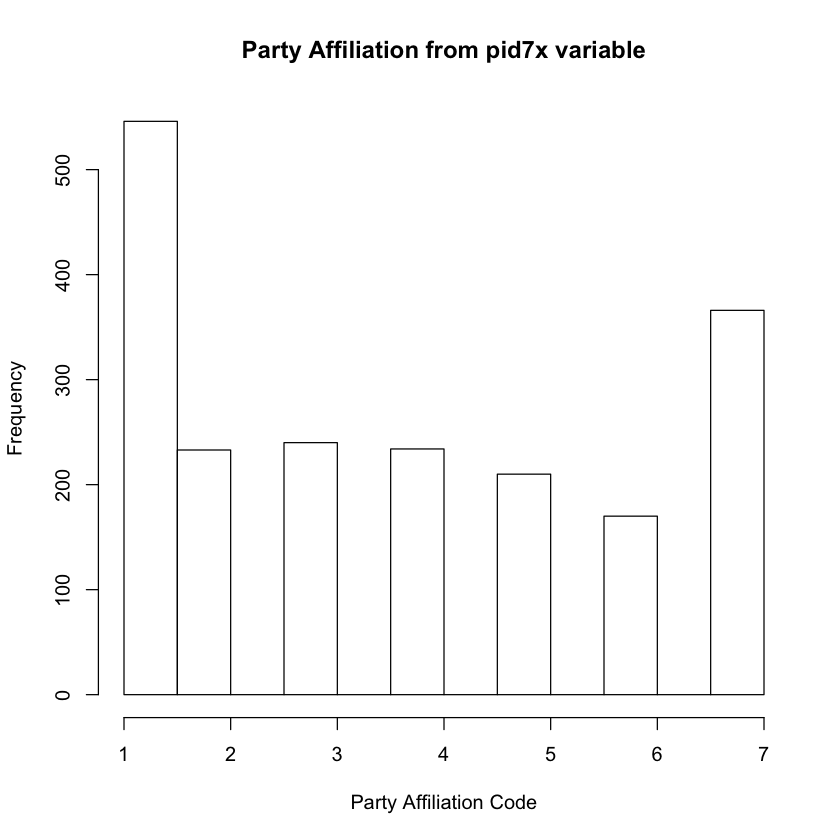

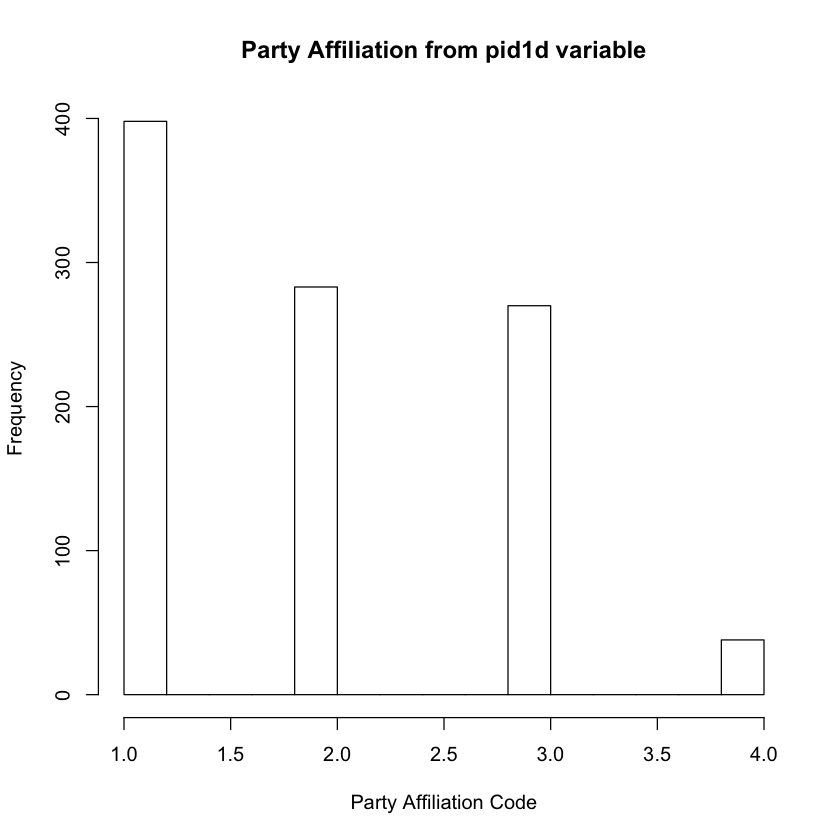

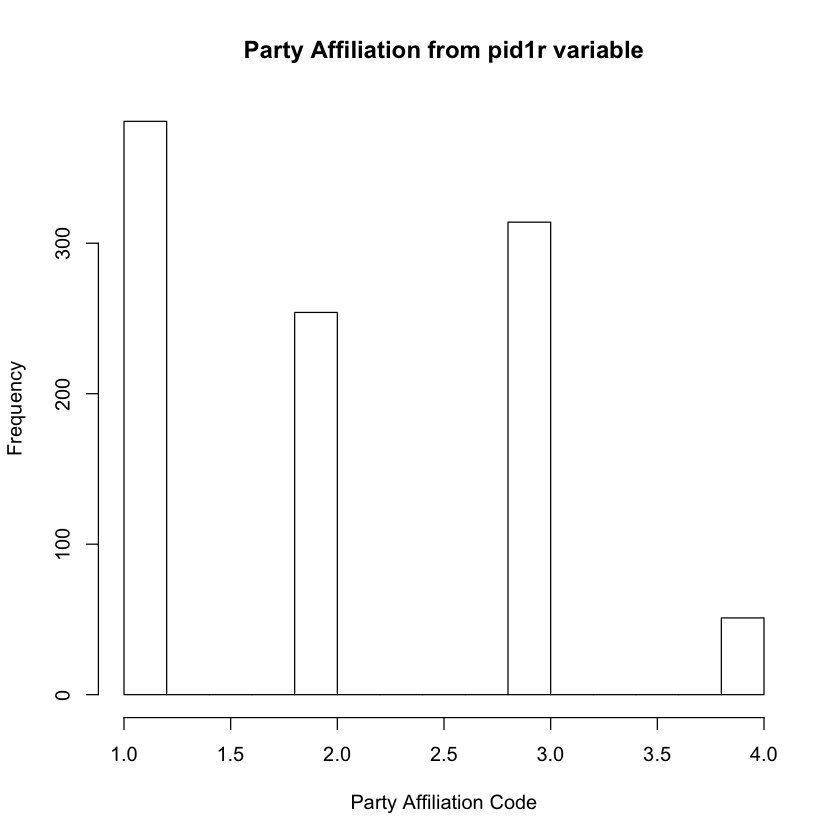

In [188]:
#First we subset the main data to only examine the party affiliation variables.
party <- survey[c("caseid","pid7x", "pid1d","pid1r", "reg")]
party <- party[party$reg != 3 & party$reg != -7,]

#IGNORE - Notes regarding how each data was collected:
#pid7x -> 3,4,5 = Independent, -7 = no answer -> YouGov profile survey data, collected on previously-completed questionaires.
#pid1d -> 3 = Independent, -7 = no answer, -1 = inapplicable, legitimate skip -> Question to subject about what party they think of themselves as
#pid1r -> 3 = Independent, -7 = no answer, -1 = inapplicable, legitimate skip -> Question to subject about what party they think of themselves as
#reg -> 1,2 = registered voter, 3 = not registered voter, -7 = no answer

#Produce a summary of subset
summary(party)
#Show the number of those who identifies as an independent for each variable
print(paste("pid7x length: ",length(party$caseid[party$pid7x==3|party$pid7x==4|party$pid7x==5]))) #number of independent
print(paste("pid1d length: ",length(party$caseid[party$pid1d==3]))) #number of independent
print(paste("pid1r length: ",length(party$caseid[party$pid1r==3]))) #number of independent

#Plot the histograms of party affiliations for each variable who did not skip the question or did not answer.
hist(party$pid7x[party$pid7x>=0], main='Party Affiliation from pid7x variable', xlab="Party Affiliation Code")
hist(party$pid1d[party$pid1d>=0], main='Party Affiliation from pid1d variable', xlab="Party Affiliation Code")
hist(party$pid1r[party$pid1r>=0], main='Party Affiliation from pid1r variable', xlab="Party Affiliation Code")

The EDA below shows 688 independent-subjects in either of the three variables. However, only 104 subjects used-to-be independent(`pid7x`) and are not independent after the survey(`pid1r`/`pid1d`). Therefore, `pid7x` will not be used to determine if a subject has an independent-affiliation because subjects can change their party-affliations from the past. 

In [189]:
#Subset of party affliations - only include independent affiliations for pid7x, pid1d, and pid1r variables.
party_indep <- party[party$pid7x==3|party$pid7x==4|party$pid7x==5|party$pid1d==3|party$pid1r==3,]

#Show number of subjects and sample dataframe
print(paste("Total independent subjects: ",length(party_indep$caseid)))
#head(party_indep)

#Number of subjects who were independent on pid7x (prior data) but not independent on either pid1r or pid1d (from questionaire)
print(paste("Total independent subjects pid7x and not pid1d/pid1r: ",length(party_indep[party_indep$pid1d!=3 & party_indep$pid1r!=3,]$caseid)))
#head(party_indep[party_indep$pid1d!=3&party_indep$pid1r!=3,])

[1] "Total independent subjects:  688"
[1] "Total independent subjects pid7x and not pid1d/pid1r:  104"


### EDA on Subject's Feelings Toward the Investigation 

The histograms below show a greater number of respondents believing that the russian investigations were not baseless.

     caseid          coord16         russia16        muellerinv    
 Min.   :   1.0   Min.   :-7.00   Min.   :-7.000   Min.   :-7.000  
 1st Qu.: 669.8   1st Qu.: 1.00   1st Qu.: 1.000   1st Qu.: 1.000  
 Median :1389.5   Median : 1.00   Median : 1.000   Median : 4.000  
 Mean   :1390.4   Mean   : 1.47   Mean   : 1.419   Mean   : 3.576  
 3rd Qu.:2112.2   3rd Qu.: 2.00   3rd Qu.: 2.000   3rd Qu.: 6.000  
 Max.   :2779.0   Max.   : 2.00   Max.   : 2.000   Max.   : 7.000  
      reg        
 Min.   :-7.000  
 1st Qu.: 1.000  
 Median : 1.000  
 Mean   : 1.422  
 3rd Qu.: 1.000  
 Max.   : 3.000  

[1] "coord16 length:  2499"
[1] "russia16 length:  2497"
[1] "muellerinv length:  2499"


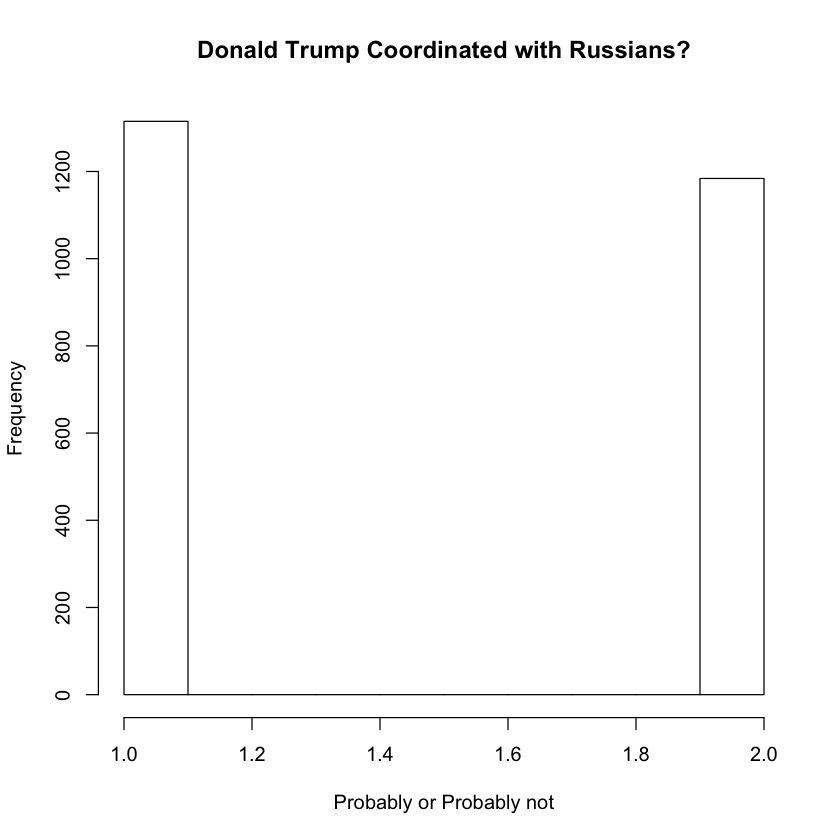

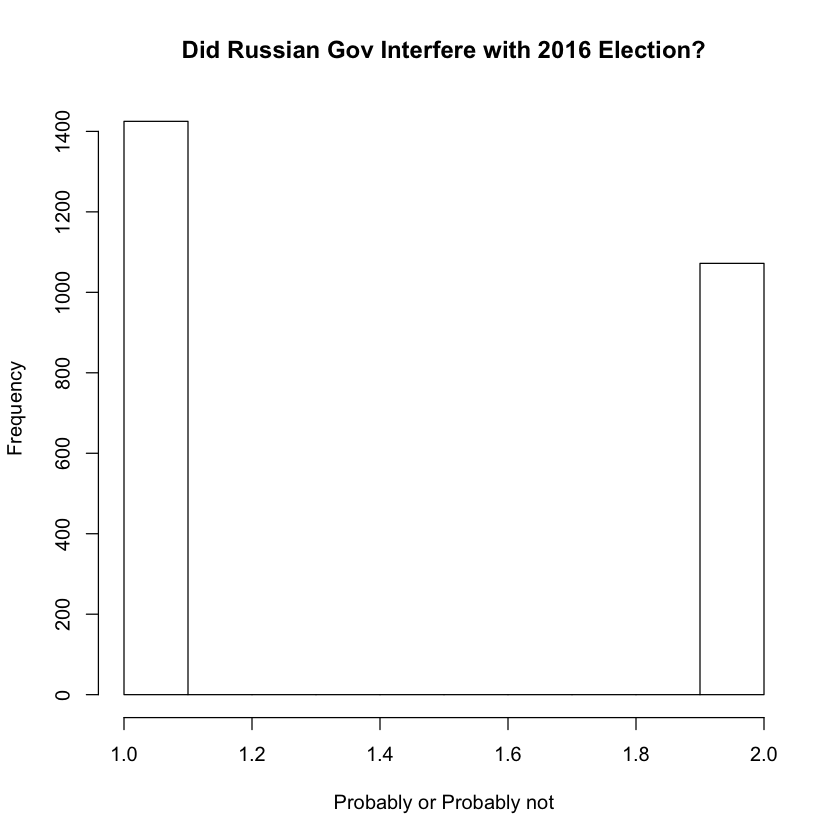

[1] "Subjects who did not respond:  5"


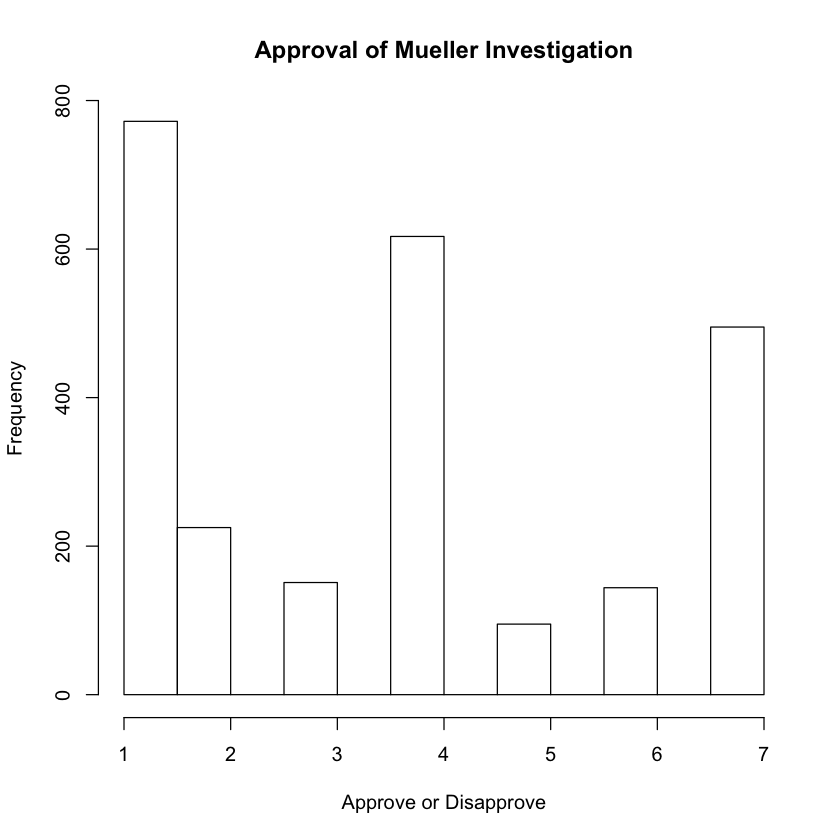

In [190]:
#First we subset the main data to only examine the subject's feeling toward the investigation variables.
rus_inv <- survey[c("caseid", "coord16", "russia16", "muellerinv", "reg")]
rus_inv <- rus_inv[party$reg != 3 & party$reg != -7,]

#IGNORE - Notes regarding how each data was collected:
#coord16 -> do you think DT compaign probably coordinated with the Russians: 1 probably, 2 probably not
#russia16 -> do you think Russian Gov probably interfered in 2016: 1 probably, 2 probably not
#muellerinv -> feelings toward mueller investigation: 1 = extremely approve, 7 = extremely disapprove

#Produce a summary of subset
summary(rus_inv)

#Show the number of subjects who actually responded for each question/variable (-7 means that they did not answer)
print(paste("coord16 length: ",length(rus_inv$caseid[rus_inv$coord16!= -7]))) #filtered non-answerers
print(paste("russia16 length: ",length(rus_inv$caseid[rus_inv$russia16!= -7]))) #filtered non-answerers
print(paste("muellerinv length: ",length(rus_inv$caseid[rus_inv$muellerinv!= -7]))) #filtered non-answerers

#Plot the histograms of responses for each variable who did not skip the question or did not answer.
hist(rus_inv$coord16[rus_inv$coord16 !=-7], main='Donald Trump Coordinated with Russians?', xlab="Probably or Probably not")
hist(rus_inv$russia16[rus_inv$russia16 !=-7], main='Did Russian Gov Interfere with 2016 Election?', xlab="Probably or Probably not")
hist(rus_inv$muellerinv[rus_inv$muellerinv !=-7], main='Approval of Mueller Investigation', xlab="Approve or Disapprove")

#Only 5 subjects who did not respond to either coord16, russia16, or muellerinv questions.
did_not_respond <- nrow(rus_inv[rus_inv$coord16== -7,]) + nrow(rus_inv[rus_inv$russia16== -7,]) + nrow(rus_inv[rus_inv$muellerinv== -7,])
print(paste("Subjects who did not respond: ",did_not_respond)) #filtered non-answerers

## Based on your EDA, select an appropriate hypothesis test.

### Underlying Data and Types of Variables

* `muellerinv` variable is ordinal. Response to `muellerinv` is a 7-point scale from 1 (strongly-approve) to 7 (strongly-disapprove). We cannot confirm the interval between each point is the same.  
* `coord16` and `russia16` variables are binary, however, we are measuring the average of the 0's and 1's. The average converges to a normal distribution.

There are no pairings for each statistical testing (each test requires a person to only answer once).  

A Wicoxon rank-sum statistical test will be conducted on `muellerinv` variable and a t-test will be conducted for the `coord16` and `russia16` variables.

### Assumptions

All tests assumes I.I.D. (the data was gathered independently-and-identically-distributed)

Assumption for Wicoxon rank-sum test:  

* Ordinal scale and Unpaired data are satisfied.
* Data is nonparametric.

Assumption for t-test:  

* Although the data is binary, metric scale can be applied for the average of the binaries.
* Data is normal since the average converges to a normal distribution in the long run.

## Conduct your test.

Note: Voters = Independent Voters

**$H_o$: Null Hypotheses**

1. Voters believing Trump's campaign probably coordinated and probably-not coordinated are equal.
2. Voters believe Russian Government probably interfered and probably-not interfered are equal.
3. Voters approving and disapproving Mueller Investigations are equal.

**$H_a$:Alternate Hypothesis**

1. Voters believing Trump's campaign probably coordinated and probably-not coordinated are NOT equal.
2. Voters believe Russian Government probably interfered and probably-not interfered are NOT equal.
3. Voters approving and disapproving Mueller Investigations are NOT equal.

In [191]:
#Subset data for independent voters:
party <- survey[c("caseid", "pid1d","pid1r", "reg", "coord16", "russia16", "muellerinv")]
party <- party[party$reg != 3 & party$reg != -7,]

Party_Independent <- party[party$pid1d==3|party$pid1r==3,]

#Subset the data to only those who answered each variable:
Party_Independent_coord16 <- Party_Independent[Party_Independent$coord16!= -7,]
Party_Independent_coord16$coord16 <- Party_Independent_coord16$coord16-1

Party_Independent_russia16 <- Party_Independent[Party_Independent$russia16!= -7,]
Party_Independent_russia16$russia16 <- Party_Independent_coord16$russia16-1

Party_Independent_muellerinv <- Party_Independent[Party_Independent$muellerinv!= -7,]

In [192]:
#Testing coord16 Variable:
# Null Hypothesis: There is an equal number of independent voters thinking that Donald Trump's 
#                  campaign probably and probably not coordinated with the Russians. 

#Running the t-test
t.test(Party_Independent_coord16$coord16, mu=0.5)
#The result shows a p-value of 0.4084 meaning that we fail to reject the null hypothesis. See summary below. 


	One Sample t-test

data:  Party_Independent_coord16$coord16
t = -0.82738, df = 583, p-value = 0.4084
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4422294 0.5235240
sample estimates:
mean of x 
0.4828767 


In [193]:
#Testing russia16 Variable
# Null Hypothesis: There is an equal number of independent voters thinking that the Russian Government 
#                  probably and probably not interfered with the 2016 elections. 

#Running the t-test
t.test(Party_Independent_russia16$russia16, mu=0.5)
#The result shows a p-value of 0.0004837 meaning that we can reject the null hypothesis. 
#   t-value is negative so the rejection region is to the left (towards probably intereference).
#   See summary below. 


	One Sample t-test

data:  Party_Independent_russia16$russia16
t = -3.5095, df = 583, p-value = 0.0004837
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.3878340 0.4683304
sample estimates:
mean of x 
0.4280822 


In [194]:
#Testing muellerinv Variable
# Null Hypothesis: There is an equal number of independent voters approving and disapproving
#                  the Mueller investigations. 

#To run the rank-sum test, the data must be subset into approved and disapproved.
mueller_approve <- Party_Independent_muellerinv$muellerinv[Party_Independent_muellerinv$muellerinv<4]  #approve = 1,2,3
mueller_disapprove <- Party_Independent_muellerinv$muellerinv[Party_Independent_muellerinv$muellerinv>4] #disapprove = 7,6,5

#The disapprove subset needs to convert to scales of 1,2,3 to be able to compare with approve scale of 1,2,3
#7 would compare to 1, 6 would compare to 2, and 5 would compare to 3. 
mueller_disapprove <- abs(mueller_disapprove-8)
#Data for neither approve or disapprove is not needed and not used since it is irrelevant to answering the question

#Running the Wilcoxon rank sum test
wilcox.test(mueller_approve, mueller_disapprove, paired=FALSE, conf.int=T)

#The result shows a p-value of 0.2967 meaning that we fail to reject the null hypothesis. See summary below. 


	Wilcoxon rank sum test with continuity correction

data:  mueller_approve and mueller_disapprove
W = 25478, p-value = 0.2967
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -1.093905e-05  5.097744e-05
sample estimates:
difference in location 
         -6.281745e-05 


In [195]:
#Practical Testing

#Conducting a "headline test" which is just mean1 - mean2:
#coord16 Variable:
coord16_mean <- 0.4828767
pop_mean <- 0.5
print(paste("coord16 variable sample versus population", coord16_mean-pop_mean))

#russia16
russia16_mean <-0.4280822  
pop_mean <- 0.5
print(paste("russia16 variable sample versus population", russia16_mean-pop_mean))

#muellerinv Variable:
library(effsize)
cohen.d(mueller_approve , mueller_disapprove , na.rm = T)
print(paste("Cohen's d of muellerinv variable:-0.09249959 (negligible)"))

[1] "coord16 variable sample versus population -0.0171233"
[1] "russia16 variable sample versus population -0.0719178"



Cohen's d

d estimate: -0.09249959 (negligible)
95 percent confidence interval:
      lower       upper 
-0.27718717  0.09218799 

[1] "Cohen's d of muellerinv variable:-0.09249959 (negligible)"


### Summary of Tests

* `coord16`:T-test shows p-value of 0.4084, failing to reject the null-hypothesis.  
* `russia16`:T-test shows p-value of 0.0004837, outside 95% CI, rejecting the null-hypothesis. The t-value is negative showing the rejection region to the left (towards probably interfered).
* `muellerinv`:Ranked-sum test shows p-value of 0.2967, failing to reject the null-hypothesis.  

The practical significance for all three variables were very low and hence, the results are not very practical.

### Conclusion

Two of three statistical tests show that there isn't sufficient evidence that the majority of independent voters believe Trumps' campaign probably-not coordinated with the Russians and show disapproval of mueller investigations. However, there's sufficient evidence to show that there is a majority of independent voters who believe that the Russian Government probably interfered with the 2016 elections. **Therefore, the statistical tests do NOT support the statement that the majority of independent voters believe that the federal investigations of Russian election interference is baseless.**  

However, the result show little practical significance meaning that it may not be helpful to apply this result to influence independent voters for future elections.

# Question 4: Was anger or fear more effective at driving increases in voter turnout from 2016 to 2018?

## Introduce your topic briefly.

### Introduction

We want to investigate whether anger or fear was more impactful in increasing voter turnout between 2016 and 2018. 

### Concepts 

The main subset of our survey-takers is the group of people who did not vote in 2016 but voted in 2018. Of these, we are interested in whether anger or fear was the prevalent emotion. There are two variables for each year that we use to calculate whether or not someone voted: 

1. In that election, did you definitely vote, definitely not vote, or are you not completely sure whether you voted? (`turnout16`/`turnout18`)
2. Do you think you probably voted or probably did not vote? (`turnout16b`/`turnout18ns`)

Additionally, there are two variables that we are interested in to determine someone's emotions: 

1. How angry/afraid do you feel about the way things are going in the country? (`geangry`/`geafraid`)
2. How angry/afraid because of Donald Trump? (`dtangry`/`dtafraid`)

There is a third emotion variable that relates to immigration. However, this variable decreases our sample size too much and it was too specific to answer the question posed, so we did not add it to analysis.

### Discrepancies

There isn't one single variable that can be analyzed to directly answer the main question. Therefore, we will conduct separate testing on the most relevant variables. 

Another thing to note is that the elections in 2016 and 2018 are in general not entirely comparable. The 2016 election was the general presidential election, while the 2018 election was the midterm election for Senate and House of Representative seats. Studies have shown that [voter turnout always drops off for midterm elections](https://www.pewresearch.org/fact-tank/2014/07/24/voter-turnout-always-drops-off-for-midterm-elections-but-why/) and that [those that do vote in the midterm are more likely to be more educated](https://www.rasmussenreports.com/public_content/political_commentary/commentary_by_larry_j_sabato/how_midterms_do_and_do_not_differ_from_presidential_elections). Because this question specifically addresses the comparison between the 2016 and 2018 election, we may have some unseen effects due to this difference. 

Lastly, while we can measure the overall emotion of those that voted in 2018 but not 2016, we cannot fully answer the question in a causal manner. In other words, even if we do find that one emotion was prevalent in a statistically significant way over the other, we cannot be sure that the emotion we see is what actually *drove* voter turnout. Voters may have chosen to vote in 2018 for many other reasons (e.g.: they lived in a state where they felt one candidate was guaranteed to win in 2016, etc). 

## Perform an exploratory data analysis (EDA) of the relevant variables.

### Finding Voters

Our first step is to subset our data to isolate voters that did not vote in 2016 but did vote in 2018.

In [196]:
# Whether you voted: (`turnout16` and `turnout18`)
# If you think you voted if you answered "not sure" to the first question (`turnout16b` and `turnout18ns`). 

survey_subset <- survey %>% select(caseid, form, turnout16, turnout16b, turnout18, turnout18ns)
survey_subset %>% head(5)

,caseid,form,turnout16,turnout16b,turnout18,turnout18ns
,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,1,-1,1,-1
2,2,2,2,-1,4,-1
3,3,1,2,-1,4,-1
4,4,1,3,-7,5,1
5,5,2,1,-1,1,-1


If someone answered "not completely sure" to question 1, we will use their answer in question 2 as their vote status for that year. 

In [197]:
# We assign final variables depicting turnout: `turnout_16_final` and `turnout_18_final`.

# Voter Turnout Enums (turnout16):
# 1: Definitely voted
# 2: Definitely did not vote
# 3: Not completely Sure

# Voter Turnout Enums (turnout18):
# 1:3: Definitely voted
# 4: Definitely did not vote
# 5: Not completely Sure

# Voter Turnout Enums For Not Completely Sure (turnout16b and turnout18ns)
# -7: No answer
# -1: Legitimate skip
# 1: Probably voted
# 2: Probably did not vote

voter_turnout <- survey_subset %>%
    mutate(
        turnout_16_final = ifelse(
            turnout16 %in% c(1), 
            T, 
            ifelse(
                turnout16 == 3 & turnout16b == 1,
                T,
                F
            )
        )
    ) %>%
    mutate(
        turnout_18_final = ifelse(
            turnout18 %in% c(1, 2, 3), 
            T, 
            ifelse(
                turnout18 == 5 & turnout18ns == 1,
                T,
                F
            )
        )
    )

In [198]:
# Following the ANES user guide, we also remove situations where the survey taker did not answer the question or had a legitimate skip. Filtering by this and pulling only individuals who answered gives us:

valid_voters <- voter_turnout %>% filter(turnout_16_final == F & turnout_18_final == T & turnout16 > 0 & turnout16b > -6)

In [199]:
valid_voters %>% head(5)
cat("Number of valid voters:", nrow(valid_voters))

,caseid,form,turnout16,turnout16b,turnout18,turnout18ns,turnout_16_final,turnout_18_final
,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>,<lgl>
1,33,1,2,-1,1,-1,FALSE,TRUE
2,108,2,2,-1,3,-1,FALSE,TRUE
3,193,1,2,-1,1,-1,FALSE,TRUE
4,216,1,2,-1,3,-1,FALSE,TRUE
5,245,1,2,-1,1,-1,FALSE,TRUE


Number of valid voters: 116

### Getting Voter Emotional Data

In [200]:
survey_emotion <- survey %>% 
    select(caseid, geangry, geafraid, dtangry, dtafraid, imangry, imafraid)

In [201]:
voter_emotions <- valid_voters %>% inner_join(survey_emotion, by = "caseid") %>%
    select(caseid, form, turnout_16_final, turnout_18_final, geangry, geafraid, dtangry, dtafraid, imangry, imafraid)

In [202]:
voter_emotions %>% head(5)

,caseid,form,turnout_16_final,turnout_18_final,geangry,geafraid,dtangry,dtafraid,imangry,imafraid
,<int>,<int>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,FALSE,TRUE,2,2,2,2,-1,-1
2,108,2,FALSE,TRUE,4,4,-1,-1,1,1
3,193,1,FALSE,TRUE,1,3,3,3,-1,-1
4,216,1,FALSE,TRUE,3,4,3,2,-1,-1
5,245,1,FALSE,TRUE,3,5,3,3,-1,-1


### Emotion Exploration

For each section of the analysis between global emotions vs. feelings toward Donald Trump, both anger and fear in that category must be filled in. 

In [203]:
# Global emotion
ge_comparison <- voter_emotions %>% 
    filter_at(vars(geangry, geafraid), all_vars(. >= 1)) %>%
    select(geangry, geafraid) %>%
    dplyr::rename(angry = geangry, afraid = geafraid)

cat("Number of valid voters for global emotion:", nrow(ge_comparison), "\n")

# Donald Trump emotion
dt_comparison <- voter_emotions %>% 
    filter_at(vars(dtangry, dtafraid), all_vars(. >= 1)) %>%
    select(dtangry, dtafraid) %>%
    dplyr::rename(angry = dtangry, afraid = dtafraid)

cat("Number of valid voters for Donald Trump emotion:", nrow(dt_comparison), "\n")


Number of valid voters for global emotion: 113 
Number of valid voters for Donald Trump emotion: 66 


We decided not to combine any of these variables since we have no reliable way of understanding which question should be weighted more heavily (i.e.: did how people felt globally or how they felt of Donald Trump have higher impact?). 

As such, we chose to approach this analysis in sections.

### Distribution of Emotions

#### Global Emotion

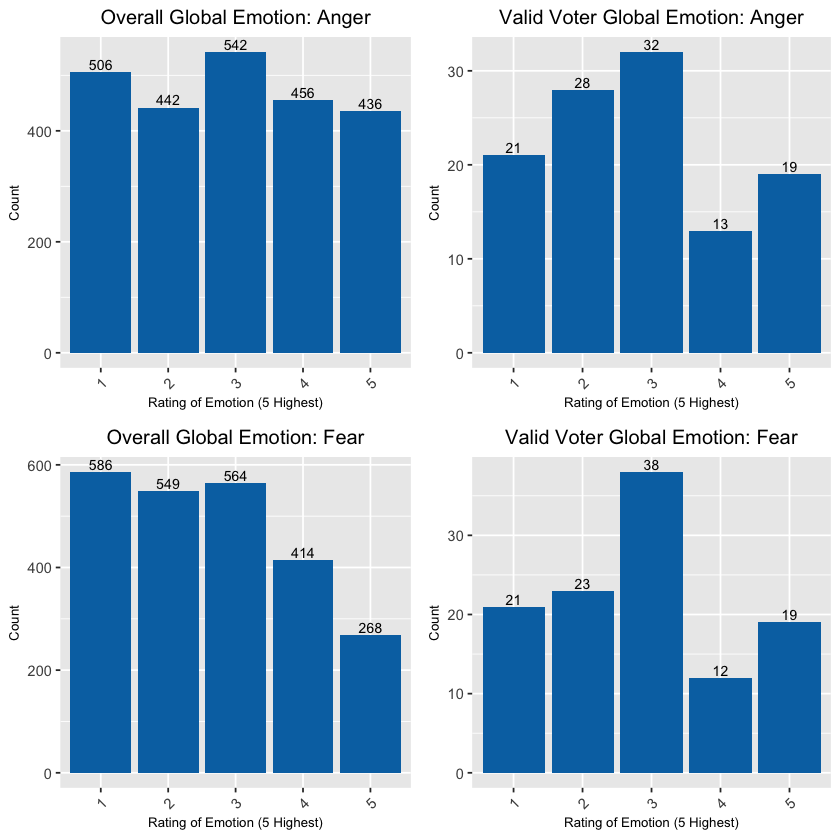

In [204]:
ge_overall_anger_plot <- ggplot(survey %>% anti_join(valid_voters, by = "caseid") %>% filter(geangry > 0), aes(as.factor(geangry))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Rating of Emotion (5 Highest)") + ylab("Count") + 
    ggtitle("Overall Global Emotion: Anger") +
    theme(plot.title = element_text(hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title = element_text(size=8)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)

ge_voter_anger_plot <- ggplot(ge_comparison %>% filter(angry > 0), aes(as.factor(angry))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Rating of Emotion (5 Highest)") + ylab("Count") + 
    ggtitle("Valid Voter Global Emotion: Anger") +
    theme(plot.title = element_text(hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title = element_text(size=8)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)

ge_overall_fear_plot <- ggplot(survey %>% anti_join(valid_voters, by = "caseid") %>% filter(geafraid > 0), aes(as.factor(geafraid))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Rating of Emotion (5 Highest)") + ylab("Count") + 
    ggtitle("Overall Global Emotion: Fear") +
    theme(plot.title = element_text(hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title = element_text(size=8)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)

ge_voter_fear_plot <- ggplot(ge_comparison %>% filter(afraid > 0), aes(as.factor(afraid))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Rating of Emotion (5 Highest)") + ylab("Count") + 
    ggtitle("Valid Voter Global Emotion: Fear") +
    theme(plot.title = element_text(hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title = element_text(size=8)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)


ggarrange(ge_overall_anger_plot, ge_voter_anger_plot, ge_overall_fear_plot, ge_voter_fear_plot, 
          ncol = 2, nrow = 2)

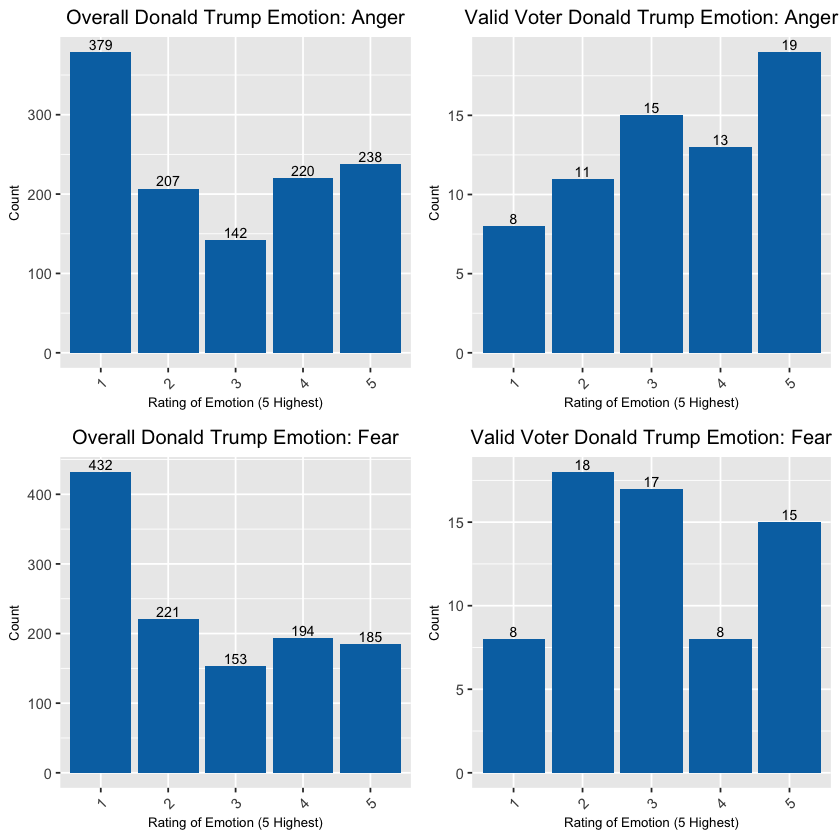

In [205]:
dt_overall_anger_plot <- ggplot(survey %>% anti_join(valid_voters, by = "caseid") %>% filter(dtangry > 0), aes(as.factor(dtangry))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Rating of Emotion (5 Highest)") + ylab("Count") + 
    ggtitle("Overall Donald Trump Emotion: Anger") +
    theme(plot.title = element_text(hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title = element_text(size=8)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)

dt_voter_anger_plot <- ggplot(dt_comparison %>% filter(angry > 0), aes(as.factor(angry))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Rating of Emotion (5 Highest)") + ylab("Count") + 
    ggtitle("Valid Voter Donald Trump Emotion: Anger") +
    theme(plot.title = element_text(hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title = element_text(size=8)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)

dt_overall_fear_plot <- ggplot(survey %>% anti_join(valid_voters, by = "caseid") %>% filter(dtafraid > 0), aes(as.factor(dtafraid))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Rating of Emotion (5 Highest)") + ylab("Count") + 
    ggtitle("Overall Donald Trump Emotion: Fear") +
    theme(plot.title = element_text(hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title = element_text(size=8)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)

dt_voter_fear_plot <- ggplot(dt_comparison %>% filter(afraid > 0), aes(as.factor(afraid))) + 
    geom_histogram(fill = "#0072B2", stat = "count") + 
    xlab("Rating of Emotion (5 Highest)") + ylab("Count") + 
    ggtitle("Valid Voter Donald Trump Emotion: Fear") +
    theme(plot.title = element_text(hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title = element_text(size=8)) + 
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.25, size = 3)


ggarrange(dt_overall_anger_plot, dt_voter_anger_plot, dt_overall_fear_plot, dt_voter_fear_plot, 
          ncol = 2, nrow = 2)

For the global emotion and the emotion regarding Donald Trump, we see that voters that voted in 2018 but not 2016 looks visible different compared to the rest of the survey. For the voters we're interested in, we see a much smaller percentage that are less angry or afraid, and a much higher percentage who felt extremely about both emotions when applied to Donald Trump.

### Comparison of Anger vs. Fear

Lastly, we want to look at the the comparison between anger/fear. 

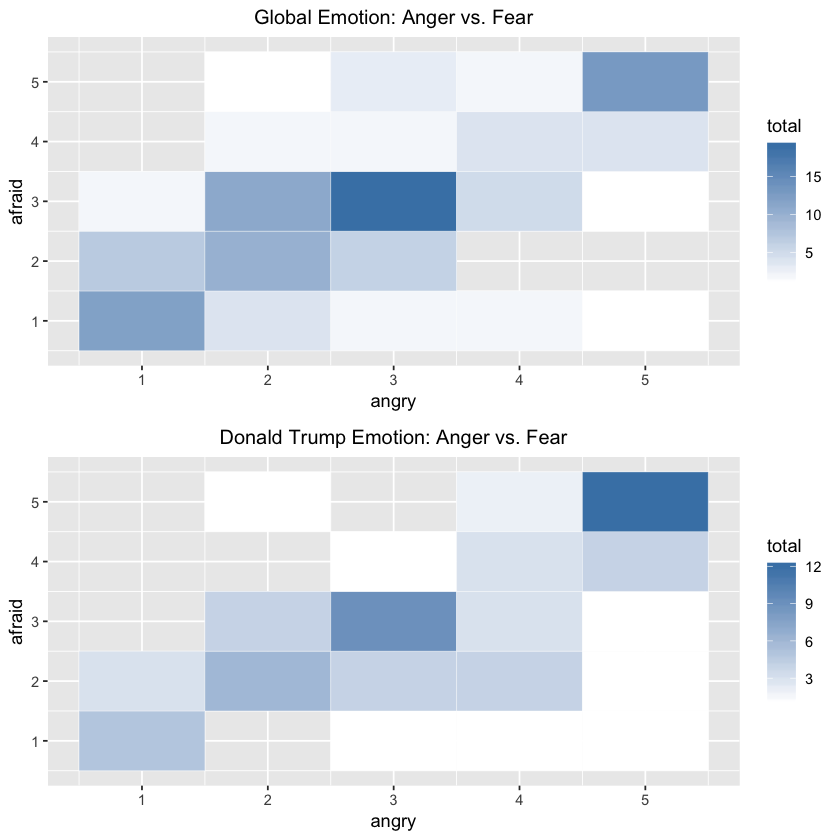

In [206]:
ge_comparison_plot <- ggplot(ge_comparison %>% group_by(angry, afraid) %>% summarise(total = n()), aes(angry, afraid, fill = total)) + 
    geom_tile(colour = "white") + 
    scale_fill_gradient(low = "white", high = "steelblue") + 
    ggtitle("Global Emotion: Anger vs. Fear") +
    theme(plot.title = element_text(hjust = 0.5, size = 12))

dt_comparison_plot <- ggplot(dt_comparison %>% group_by(angry, afraid) %>% summarise(total = n()), aes(angry, afraid, fill = total)) + 
    geom_tile(colour = "white") + 
    scale_fill_gradient(low = "white", high = "steelblue") + 
    ggtitle("Donald Trump Emotion: Anger vs. Fear") +
    theme(plot.title = element_text(hjust = 0.5, size = 12))

ggarrange(ge_comparison_plot, dt_comparison_plot, nrow = 2)

We can kind of visualize here that the Donald Trump emotion may trend more towards anger than fear, but it's difficult to assess by how much. We take our data and proceed with the hypothesis testing. 

## Based on your EDA, select an appropriate hypothesis test.

### Underlying Data and Types of Variables

Both the `angry` and `afraid` variables for each question is ordinal. The scale ranges from `1=Not at all` to `5=Extremely`. We cannot confirm that the interval between each point is the same. 

To determine which emotion is actually dominant in asking what drove voter increases, we will check which was the more extreme emotion. We assign `0` to one emotion and `1` for another emotion. 

Because of these variable types, we will use a two different tests: 

* For the comparison of emotions across increased voters and the rest of the sample, we use the Wilcoxon rank-sum as it's unpaired and ordinal. 
* For the comparison of anger/fear in the increased voters, whch is `0` and `1`, we use paired sign/binomial test. 

### Testing Assumptions

All tests assume i.i.d.

The assumption for an ordinal scale is satisfied. The two random variables are independent: we assume that a person's feeling of fear is independent from that of anger and vice versa. As we are using a non-parametric test, we do not need to assume that the data is normally distributed.

## Conduct your test.

We break up our testing into a few sections:

1. Looking at the difference between the subset of voters that did not vote in 2016 but did in 2018, compared to the rest of the sample
    * Global anger/fear between the two groups
    * Donald Trump anger/fear between the two groups
2. Looking at the difference anger vs. fear makes specifically in the subset of voters that did not vote in 2016 but did in 2018
    * Global emotion anger vs. fear
    * Donald Trump emotion anger vs. fear
    
For all of these following tests, our null and alternate hypotheses are as follows:

**$H_0$: Null Hypothesis**

* Fear = Anger

**$H_a$: Alternate Hypothesis**

* Fear != Anger

### Global Emotion

#### Increased Voters vs. Rest of Survey

In [207]:
no_increase_voters_ge <- survey %>% 
    anti_join(valid_voters, by = "caseid") %>% 
    filter(geangry > 0 & geafraid > 0) %>% 
    select(caseid, geangry, geafraid) %>%
    rename(angry = geangry, afraid = geafraid)

In [208]:
# Anger

wilcox.test(ge_comparison$angry, no_increase_voters_ge$angry, paired = F, conf.int = T)
cohen.d(ge_comparison$angry, no_increase_voters_ge$angry, paired = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  ge_comparison$angry and no_increase_voters_ge$angry
W = 128079, p-value = 0.3788
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -4.085052e-05  2.219107e-05
sample estimates:
difference in location 
         -3.429865e-05 



Cohen's d

d estimate: -0.08253187 (negligible)
95 percent confidence interval:
     lower      upper 
-0.2713399  0.1062761 

In [209]:
# Fear

wilcox.test(ge_comparison$afraid, no_increase_voters_ge$afraid, paired = F, conf.int = T)
cohen.d(ge_comparison$afraid, no_increase_voters_ge$afraid, paired = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  ge_comparison$afraid and no_increase_voters_ge$afraid
W = 145356, p-value = 0.138
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -7.897809e-05  2.008924e-06
sample estimates:
difference in location 
           2.27218e-05 



Cohen's d

d estimate: 0.1450798 (negligible)
95 percent confidence interval:
      lower       upper 
-0.04375724  0.33391687 

#### Emotions For Voter Increase

In [210]:
# For our test, let 0 be angry and 1 be afraid
# We will remove all neutrals

ge_comparison_angry <- sum((ge_comparison$angry - ge_comparison$afraid) > 0)
ge_comparison_afraid <- sum((ge_comparison$angry - ge_comparison$afraid) < 0)

In [211]:
binom.test(
    c(ge_comparison_afraid, ge_comparison_angry),
    alternative = "two.sided",
    conf.level = 0.95
)


	Exact binomial test

data:  c(ge_comparison_afraid, ge_comparison_angry)
number of successes = 30, number of trials = 55, p-value = 0.5901
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.4055449 0.6802993
sample estimates:
probability of success 
             0.5454545 


In [212]:
cohen.d(ge_comparison$angry, ge_comparison$afraid, paired = TRUE)


Cohen's d

d estimate: -0.02679694 (negligible)
95 percent confidence interval:
     lower      upper 
-0.1744005  0.1208067 

### Donald Trump Emotion

#### Increased Voters vs. Rest of Survey

In [213]:
no_increase_voters_dt <- survey %>% 
    anti_join(valid_voters, by = "caseid") %>% 
    filter(dtangry > 0 & dtafraid > 0) %>% 
    select(caseid, dtangry, dtafraid) %>%
    rename(angry = dtangry, afraid = dtafraid)

In [214]:
# Anger

wilcox.test(dt_comparison$angry, no_increase_voters_dt$angry, paired = F, conf.int = T)
cohen.d(dt_comparison$angry, no_increase_voters_dt$angry, paired = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  dt_comparison$angry and no_increase_voters_dt$angry
W = 47820, p-value = 0.00173
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 6.034563e-05 1.000039e+00
sample estimates:
difference in location 
              0.999989 



Cohen's d

d estimate: 0.3844948 (small)
95 percent confidence interval:
    lower     upper 
0.1359141 0.6330754 

In [215]:
# Fear

wilcox.test(dt_comparison$afraid, no_increase_voters_dt$afraid, paired = F, conf.int = T)
cohen.d(dt_comparison$afraid, no_increase_voters_dt$afraid, paired = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  dt_comparison$afraid and no_increase_voters_dt$afraid
W = 47506, p-value = 0.002403
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 7.736167e-05 9.999787e-01
sample estimates:
difference in location 
             0.9999265 



Cohen's d

d estimate: 0.335824 (small)
95 percent confidence interval:
     lower      upper 
0.08735189 0.58429620 

#### Emotions For Voter Increase

In [216]:
# For our test, let 0 be angry and 1 be afraid
# We will remove all neutrals

dt_comparison_angry <- sum((dt_comparison$angry - dt_comparison$afraid) > 0)
dt_comparison_afraid <- sum((dt_comparison$angry - dt_comparison$afraid) < 0)

In [217]:
binom.test(
    c(dt_comparison_afraid, dt_comparison_angry),
    alternative = "two.sided",
    conf.level = 0.95
)


	Exact binomial test

data:  c(dt_comparison_afraid, dt_comparison_angry)
number of successes = 11, number of trials = 31, p-value = 0.1496
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.1922674 0.5463044
sample estimates:
probability of success 
             0.3548387 


In [218]:
cohen.d(dt_comparison$angry , dt_comparison$afraid, paired = TRUE)


Cohen's d

d estimate: 0.2224905 (small)
95 percent confidence interval:
     lower      upper 
0.01927253 0.42570847 

### Summary

#### Global Emotion

For the comparison between increased voters and the rest of the sample, we see a p-value of 0.3788 for anger and 0.138 for fear, both trending towards less emotion. We fail to reject the null hypothesis.

The mean of the emotion for this group trends more towards fear than anger. However, we have a p-value of 0.5901, which is very high. We fail to reject the null hypothesis. 

The Cohen's D results for all these tests is also negligible. We don't see much practical significance here. 

#### Donald Trump Emotion

For the comparison between increased voters and the rest of the sample, we see a p-value of <0.05 for both anger and fear, both trending towards more emotion. We can reject the null hypothesis.

The mean of the emotion for this group trends more towards anger than fear. However, we have a p-value of 0.1496, which is very high. We fail to reject the null hypothesis. 

The Cohen's D results for all these tests is small, although the difference for anger towards Trump is larger than the others. We do see a larger practical significance than global emotion, but the results still may not be very practical. 

### Conclusion

If we **absolutely had** to answer the question posed, we would say that anger towards Donald Trump is probably the largest driving point for voter increase between 2016 and 2018. However, we're not comfortable making this claim for a few reasons: 

1. The tests for looking at the emotion within the voting increase group is not significant
2. The practical significance is very small
3. As mentioned in the set-up to this problem, we cannot be sure that whatever emotion we see is what is actually driving voter turnout. 

Thus, we may not have a concrete answer for this question. 

# Question 5: Do more Democratic voters favor background check for gun purchases than Republican voters?

## Clearly argue for the relevance of this question.

### Introduction

In the US media, Democrats are typically associated with a strict gun control policies while Republicans are associated with a relatively less strict gun control. With the high frequency of gun violence in the US and the frequent reporting of mass-shootings in the news, gun control becomes an important political issue. Our research question can determine if there actually is an association of strict gun control policies with political parties. Different political parties can, then, adjust their gun control political strategies to persuade certain types of voters to vote one way or another. 

### Methodology 

The survey includes a numeric code (instead of a system missing e.g. NA) when a participant skips/choses not to respond.

### Concepts

We will determine who are the "Democratic" and "Republican" voters and their belief on background checks for guns. We are provided with 3 categorical variables to determine a subject's party affiliation and 3 ordinal variable related to the subject's feelings toward gun purchase background checks, sale of semi-automatic rifles, and school teachers carrying guns at school.

The steps to measure these concepts will be:

1. Construct a null hypothesis.  
2. Conduct an exploratory data analysis (EDA) and prepare the data for testing. Note that an EDA has been conducted for political party association in Question 2 and therefore, will not be repeated in this section to keep this report brief.  
3. Perform three statistical and a practical significance tests, one for each variable, as described in part-3 of this question.

### Discrepancies

There isn't one single variable that can be analyzed to directly answer the main question. Therefore, we will conduct separate statistical testing on the most relevant variables to support the answer to the main question. 

By answering whether there is a similar amount of democratic and republican voters who: (1) favor requiring background checks for gun purchases at gun shows or other private sales, (2) favor banning the sale of semi-automatic rifles, and (3) oppose allowing school teachers to carry guns at school, it will help answer whether Democratic or Republican voters are more likely to favor inaccessibility of guns.


## Perform EDA and select your hypothesis test.

### EDA for Relevant Variables

Based on EDA in question 2, we have already determined what classifies as a democratic or republican voter. Based on the EDA in question 3, there are no duplicate data.

Non-response to `guncheck`, `gunsar`, and `gunteach` (-7 value) will be removed from dataset as they do not apply to our test. 

Regarding the `guncheck` variable, the histograms show a right-skewed distribution, toward favoring.  
Regarding the `gunsar` variable, the histograms show skewed distributions (right for Democrats, left for Republicans).   
Regarding the `gunteach` variable, the histograms show skewed distributions (left for Democrats, right for Republicans).  

     caseid           pid1d             pid1r            pidlean       
 Min.   :   6.0   Min.   :-1.0000   Min.   :-1.0000   Min.   :-1.0000  
 1st Qu.: 606.5   1st Qu.:-1.0000   1st Qu.:-1.0000   1st Qu.:-1.0000  
 Median :1236.0   Median :-1.0000   Median : 1.0000   Median :-1.0000  
 Mean   :1240.9   Mean   : 0.1945   Mean   : 0.2908   Mean   :-0.2957  
 3rd Qu.:1896.0   3rd Qu.: 1.0000   3rd Qu.: 1.0000   3rd Qu.:-1.0000  
 Max.   :2746.0   Max.   : 4.0000   Max.   : 4.0000   Max.   : 2.0000  
    guncheck         gunsar         gunteach          reg       
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:1.000   1st Qu.:1.000   1st Qu.:5.000   1st Qu.:1.000  
 Median :1.000   Median :1.000   Median :7.000   Median :1.000  
 Mean   :1.386   Mean   :2.053   Mean   :5.957   Mean   :1.043  
 3rd Qu.:1.000   3rd Qu.:2.000   3rd Qu.:7.000   3rd Qu.:1.000  
 Max.   :7.000   Max.   :7.000   Max.   :7.000   Max.   :2.000  

     caseid         pid1d             pid1r            pidlean       
 Min.   :   1   Min.   :-1.0000   Min.   :-7.0000   Min.   :-1.0000  
 1st Qu.: 548   1st Qu.:-1.0000   1st Qu.:-1.0000   1st Qu.:-1.0000  
 Median :1259   Median :-1.0000   Median : 2.0000   Median :-1.0000  
 Mean   :1254   Mean   : 0.6067   Mean   : 0.6819   Mean   :-0.4362  
 3rd Qu.:1920   3rd Qu.: 2.0000   3rd Qu.: 2.0000   3rd Qu.: 1.0000  
 Max.   :2779   Max.   : 4.0000   Max.   : 4.0000   Max.   : 1.0000  
    guncheck         gunsar         gunteach          reg       
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:1.000   1st Qu.:2.000   1st Qu.:1.000   1st Qu.:1.000  
 Median :2.000   Median :5.000   Median :2.000   Median :1.000  
 Mean   :3.008   Mean   :4.615   Mean   :2.753   Mean   :1.042  
 3rd Qu.:4.000   3rd Qu.:7.000   3rd Qu.:4.000   3rd Qu.:1.000  
 Max.   :7.000   Max.   :7.000   Max.   :7.000   Max.   :2.000  

[1] "Number of Democrats:  1018"
[1] "Number of Republicans:  745"


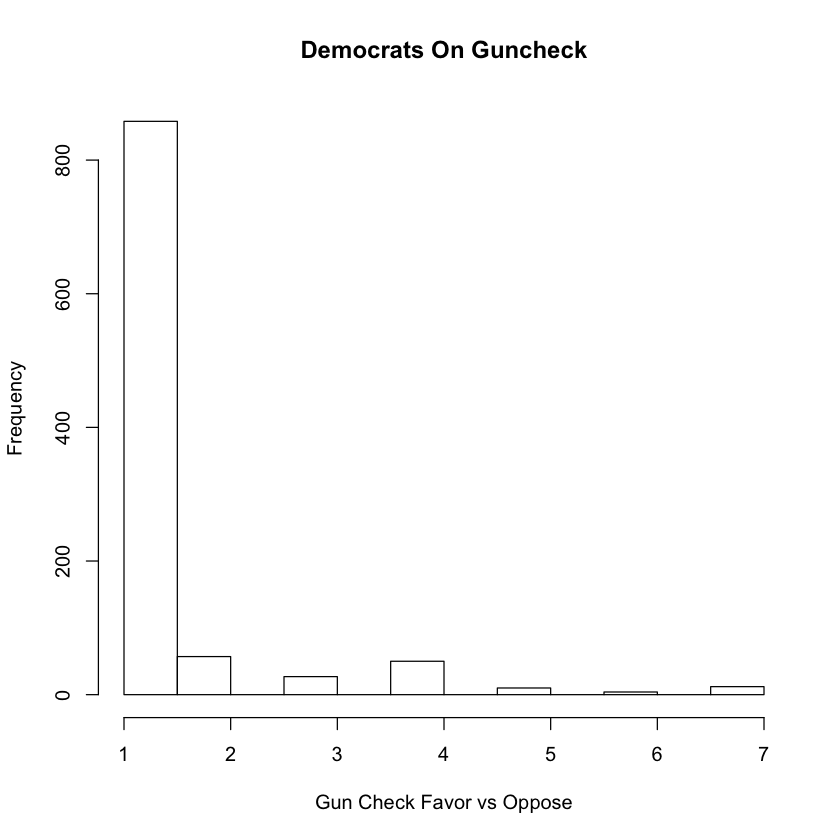

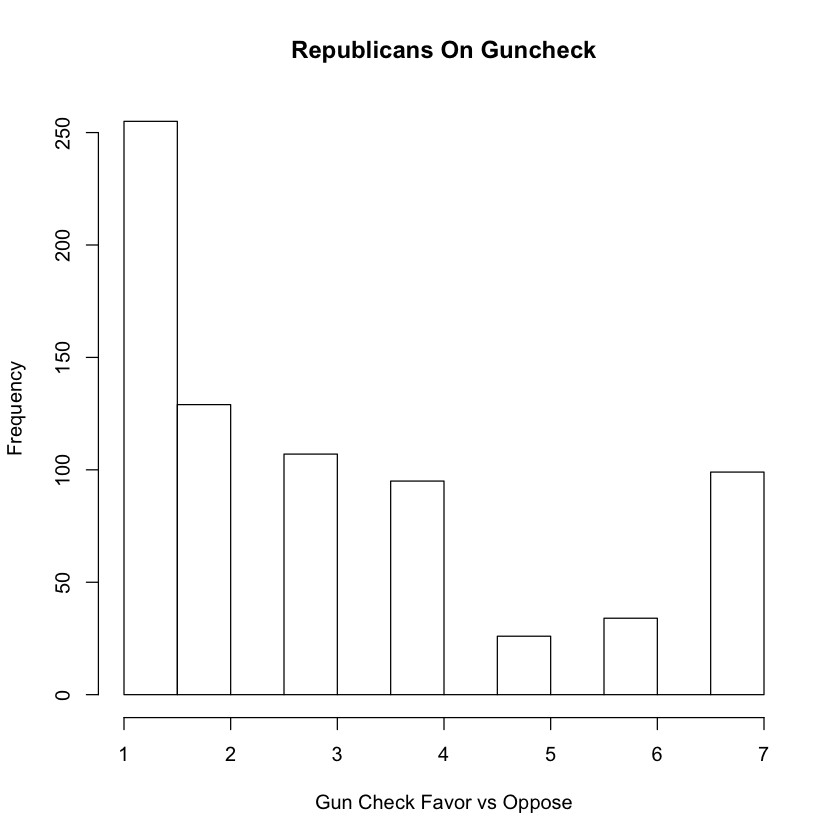

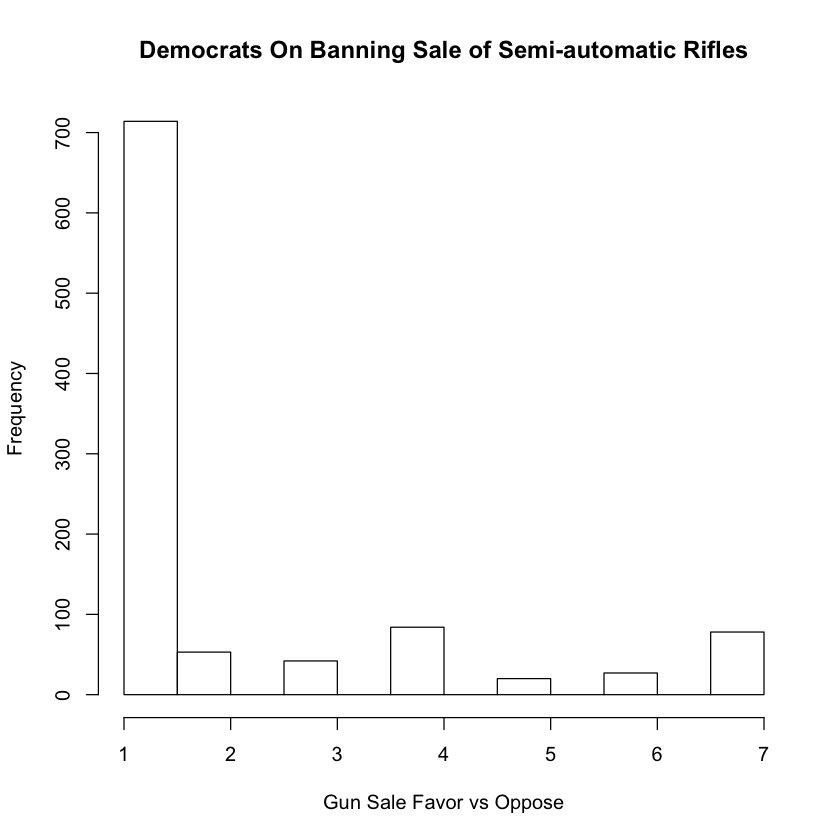

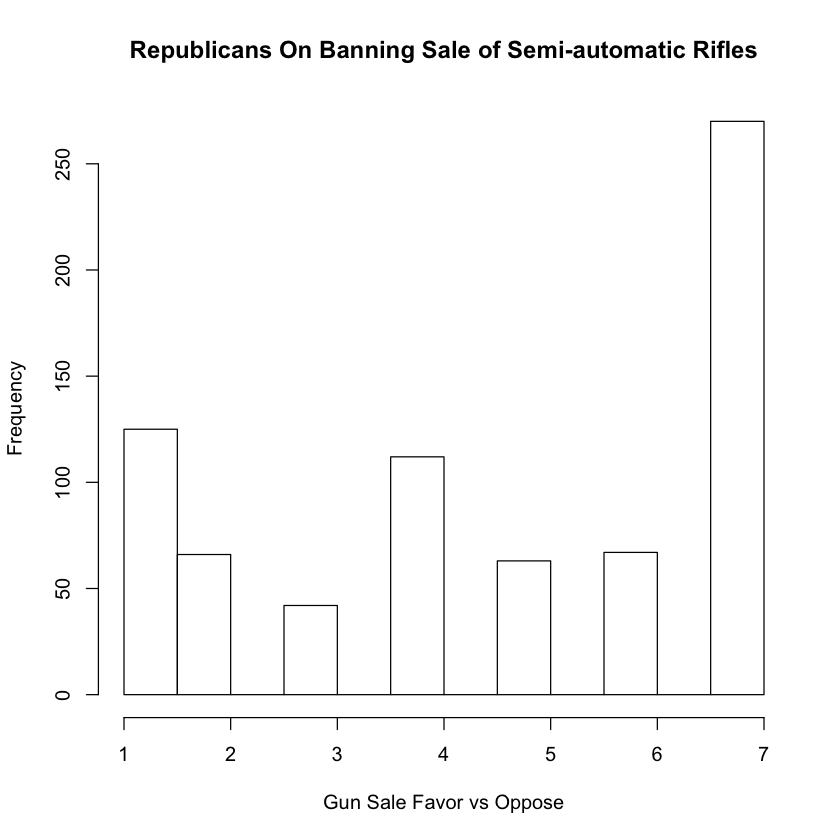

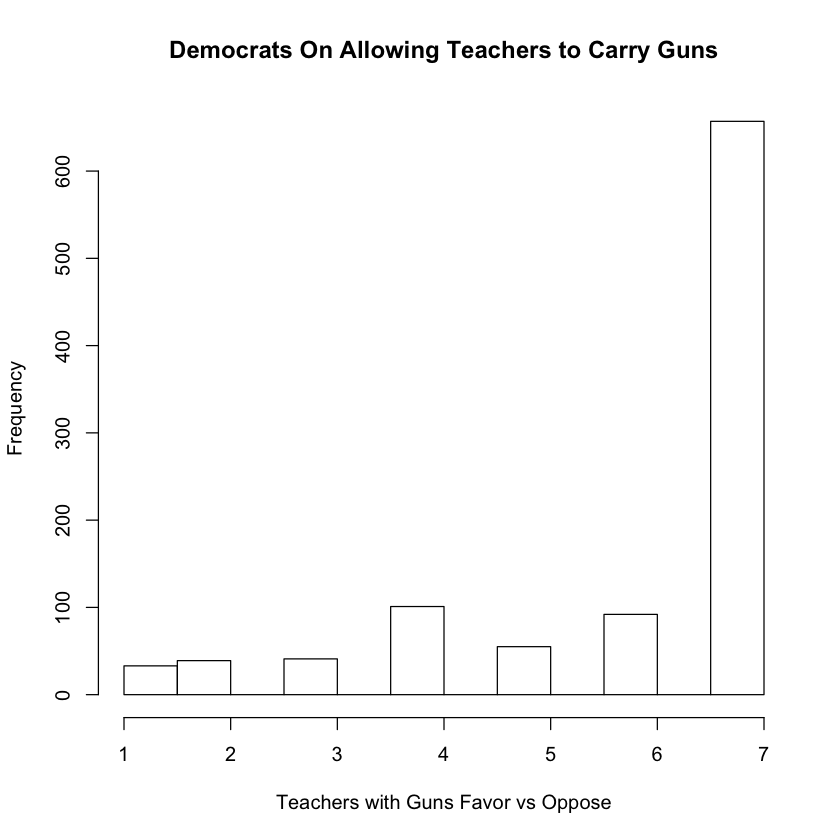

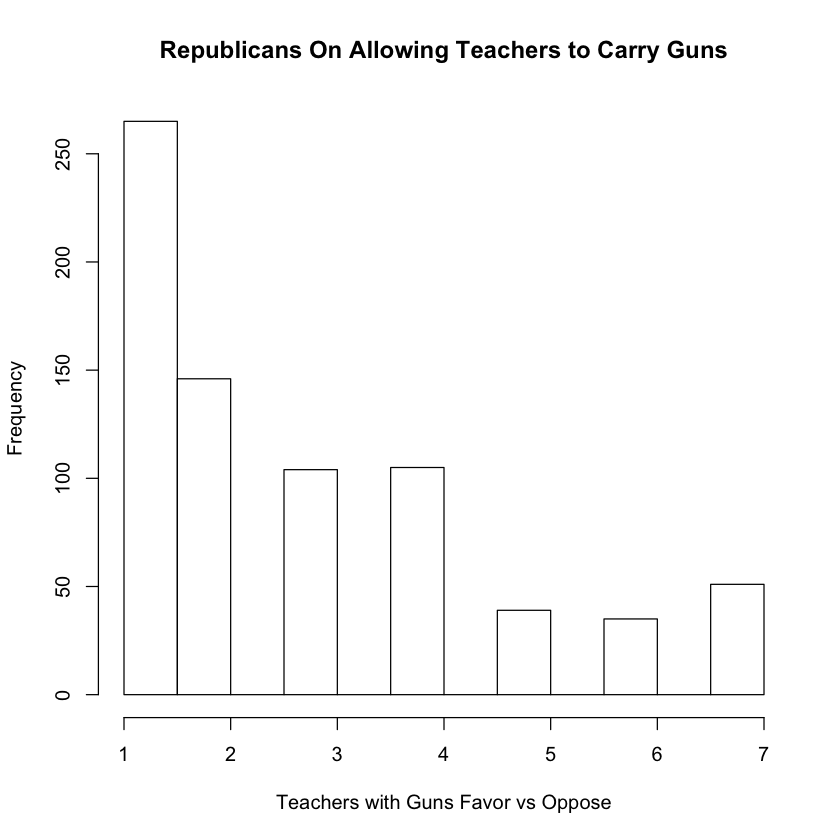

In [219]:
#First we subset the main data to only examine the party affiliation and guncheck variables.
party <- survey[c("caseid", "pid1d","pid1r", "pidlean","guncheck","gunsar", "gunteach","reg")]
party <- party[party$guncheck!=-7 & party$gunsar!=-7 & party$gunteach!=-7,]
party <- party[party$reg!=3,]

#IGNORE - Notes regarding how each data was collected:
#pid1d -> 1=Demo, 2=Rep, -7 = no answer, -1 = inapplicable, legitimate skip -> Question to subject about what party they think of themselves as
#pid1r -> 1=Demo, 2=Rep, -7 = no answer, -1 = inapplicable, legitimate skip -> Question to subject about what party they think of themselves as
#pidlean -> 1 = Closer to Rep, 2 = Closer to Demo
#guncheck -> 1,2,3 = Favors // 7,6,5 = Oppose

#Per question 2
#Demo = (pid1d==1) + (pid1r==1) + (pidlean==2)
#Rep = (pid1d==2) + (pid1r==2) + (pidlean==1) 
party_demo <- party[party$pid1d==1|party$pid1r==1|party$pidlean==2  ,]
party_rep <- party[party$pid1d==2|party$pid1r==2|party$pidlean==1 ,]

#Produce a summary of subset to check all negative values are removed
summary(party_demo)
summary(party_rep)
print(paste("Number of Democrats: ",length(party_demo$caseid))) #number of democrats
print(paste("Number of Republicans: ",length(party_rep$caseid))) #number of republicans

#Plot the histograms of party affiliations for each variable who did not skip the question or did not answer.
hist(party_demo$guncheck, main='Democrats On Guncheck', xlab="Gun Check Favor vs Oppose")
hist(party_rep$guncheck, main='Republicans On Guncheck', xlab="Gun Check Favor vs Oppose")

hist(party_demo$gunsar, main='Democrats On Banning Sale of Semi-automatic Rifles', xlab="Gun Sale Favor vs Oppose")
hist(party_rep$gunsar, main='Republicans On Banning Sale of Semi-automatic Rifles', xlab="Gun Sale Favor vs Oppose")

hist(party_demo$gunteach, main='Democrats On Allowing Teachers to Carry Guns', xlab="Teachers with Guns Favor vs Oppose")
hist(party_rep$gunteach, main='Republicans On Allowing Teachers to Carry Guns', xlab="Teachers with Guns Favor vs Oppose")

Additionally, we are only interested in cases who favor background checks, rifle sale ban, and oppose teacher carry. Therefore, we will remove the data for those who neither favor nor oppose and those who oppose background checks, rifle sale ban, and favor teacher carry. After removing, the sample sizes are still large.

In [220]:
demo_check_favor <- party_demo[party_demo$guncheck <4,]
rep_check_favor <- party_rep[party_rep$guncheck <4,]

demo_saleban_favor <- party_demo[party_demo$gunsar <4,]
rep_saleban_favor <- party_rep[party_rep$gunsar <4,]

demo_teachcarry_oppose <- party_demo[party_demo$gunteach >4,]
rep_teachcarry_oppose <- party_rep[party_rep$gunteach >4,]

length(demo_check_favor$guncheck)
length(rep_check_favor$guncheck)
length(demo_saleban_favor$guncheck)
length(rep_saleban_favor$guncheck)
length(demo_teachcarry_oppose$guncheck)
length(rep_teachcarry_oppose$guncheck)

[1] 942

[1] 491

[1] 809

[1] 233

[1] 804

[1] 125

### Underlying Data and Types of Variables

The `guncheck`, `gunsar`, and `gunteach` variables are ordinal. The response to `guncheck`, `gunsar`, and `gunteach` variables are a 7-point scale from 1(Favor-greatly) to 7(Oppose-greatly). We cannot confirm that the interval between each point is the same.

There are no pairings for each statistical testing. Each test only requires a person to answer once.  

### Assumptions 

Data is assumed to be non-normal based on the skewness findings above.

A Wicoxon rank-sum statistical test will be conducted all three variables.

Assumption for Wicoxon rank-sum test:

* The assumption for ordinal scale and unpaired data are satisfied.  
* Data is nonparametric.  
* I.I.D. - the assumption is that the data was gathered independently with identically distributed.

## Conduct your test.

**$H_o$: Null Hypothesis**

* Democratic voters and Republianc voters favoring background checks are equal.
* Democratic voters and Republican voters favoring ban of rifle sales are equal.  
* Democratic voters and Republican voters opposing teachers carrying guns are equal. 

**$H_a$: Alternate Hypothesis**

* Democratic voters and Republianc voters favoring background checks are NOT equal.
* Democratic voters and Republican voters favoring ban of rifle sales are NOT equal.  
* Democratic voters and Republican voters opposing teachers carrying guns are NOT equal. 



In [221]:
# Testing guncheck Variable
# Null Hypothesis: There is an equal number of Democratic and Republican voters in favor of background
#                  checks for gun purchases. 

#To run the rank-sum test, the data must be subset into democrats in favor and republicans in favor.
demo_check_favor <- party_demo[party_demo$guncheck <4,]
rep_check_favor <- party_rep[party_rep$guncheck <4,]
#Data for neither preference and oppose are not needed and not used since it is irrelevant to answering the question

#Running the Wilcoxon rank sum test
wilcox.test(demo_check_favor$guncheck, rep_check_favor$guncheck, paired=FALSE)

#Print p-value since it is too small to show
z_1<-wilcox.test(demo_check_favor$guncheck, rep_check_favor$guncheck, paired=FALSE)
z_1[3]

#The result shows a p-value of 2.2e-16 meaning that the null hypothesis can be rejected. See summary below. 


	Wilcoxon rank sum test with continuity correction

data:  demo_check_favor$guncheck and rep_check_favor$guncheck
W = 139419, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


$p.value
[1] 9.164076e-65

In [222]:
# Testing gunsar Variable
# Null Hypothesis: There is an equal number of Democratic and Republican voters in favor of ban
#                  on sale of rifles.

#To run the rank-sum test, the data must be subset into democrats in favor and republicans in favor.
demo_saleban_favor <- party_demo[party_demo$gunsar <4,]
rep_saleban_favor <- party_rep[party_rep$gunsar <4,]
#Data for neither preference and oppose are not needed and not used since it is irrelevant to answering the question

#Running the Wilcoxon rank sum test
wilcox.test(demo_saleban_favor$guncheck, rep_saleban_favor$guncheck, paired=FALSE)

#Print p-value since it is too small to show
z_2<-wilcox.test(demo_saleban_favor$guncheck, rep_saleban_favor$guncheck, paired=FALSE)
z_2[3]

#The result shows a p-value of 2.2e-16 meaning that the null hypothesis can be rejected. See summary below. 


	Wilcoxon rank sum test with continuity correction

data:  demo_saleban_favor$guncheck and rep_saleban_favor$guncheck
W = 69450, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


$p.value
[1] 8.578907e-25

In [223]:
# Testing gunsar Variable
# Null Hypothesis: There is an equal number of Democratic and Republican voters who oppose teacher
#                  carrying guns at school.

#To run the rank-sum test, the data must be subset into democrats in favor and republicans in favor.
demo_teachcarry_oppose <- party_demo[party_demo$gunteach >4,]
rep_teachcarry_oppose <- party_rep[party_rep$gunteach >4,]
#Data for neither preference and oppose are not needed and not used since it is irrelevant to answering the question

#Running the Wilcoxon rank sum test
wilcox.test(demo_teachcarry_oppose$guncheck, rep_teachcarry_oppose$guncheck, paired=FALSE)

#Print p-value since it is too small to show
z_3 <-wilcox.test(demo_teachcarry_oppose$guncheck, rep_teachcarry_oppose$guncheck, paired=FALSE)
z_3[3]

#The result shows a p-value of 2.2e-16 meaning that the null hypothesis can be rejected. See summary below. 


	Wilcoxon rank sum test with continuity correction

data:  demo_teachcarry_oppose$guncheck and rep_teachcarry_oppose$guncheck
W = 36256, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


$p.value
[1] 2.047607e-19

In [224]:
# Practical Testing
# Conducting the cohen's d test for all three tests.
library(effsize)

# guncheck
cohen.d(demo_check_favor$guncheck , rep_check_favor$guncheck , na.rm = T)

# gunsar
cohen.d(demo_saleban_favor$guncheck , rep_saleban_favor$guncheck , na.rm = T)

# gunteach
cohen.d(demo_teachcarry_oppose$guncheck , rep_teachcarry_oppose$guncheck , na.rm = T)


Cohen's d

d estimate: -1.014079 (large)
95 percent confidence interval:
     lower      upper 
-1.1294161 -0.8987424 


Cohen's d

d estimate: -0.6713036 (medium)
95 percent confidence interval:
     lower      upper 
-0.8200231 -0.5225841 


Cohen's d

d estimate: -0.8587613 (large)
95 percent confidence interval:
     lower      upper 
-1.0514560 -0.6660666 

The ranked-sum tests show p-value < 2.2e-16 supporting the rejection of the null-hypothesis in all-three cases. 

The practical significance is large for `guncheck` and `gunteach` but medium for `gunsar` based on the Cohen's d test.

## Conclusion

Based on the results from the statistical signifiance and practical significance testing, there is strong evidence to support that Democratic voters more likely favor background checks, favor ban of rifle sales, and oppose teachers carrying guns at school more than Republican voters. The probability of having results as extreme as the statistical testing produced is very low, outside the 95% CI, showing that our conclusion is very likely. The large and medium practical signifiance would imply that the results can create an impact on societal applications.

We have conducted three statistical tests to determine if Democratic voters are more likely to favor background checks for gun purchases than Republican voters, if Democratic voters are more likely to favor the ban of rifle sales, and if Democratic voters are more likely to oppose allowing school teachers to carry guns at school. 
The result of this testing, based on the 2018 ANES Pilot Study, shows evidence to support that more Democratic voters do favor background check for gun purchases, favor ban of rifle sales, and oppose teachers carrying guns at school than Republican voters.  In addition, the evidence is so strong that it passes a practical significance test meaning that we can likely create an impact with the results from this study.
The combination of these results support the statement that Democratic voters are more likely to favor inaccessibility of guns. 

From this conclusion, the Democratic candidates running for government positions should also support stricter gun policies. If Republican candidates wish to gain Democratic voters' support, it is worth the effort to consider if supporting background checks for gun purchases could indeed gain Democratic support.